Author: yanjun zhang
## Concise
## 1: Start

1: Total tims is  49.86 s
2: Total numb steps is  305


Text(0, 0.5, 'Brake pressure/ Pa')

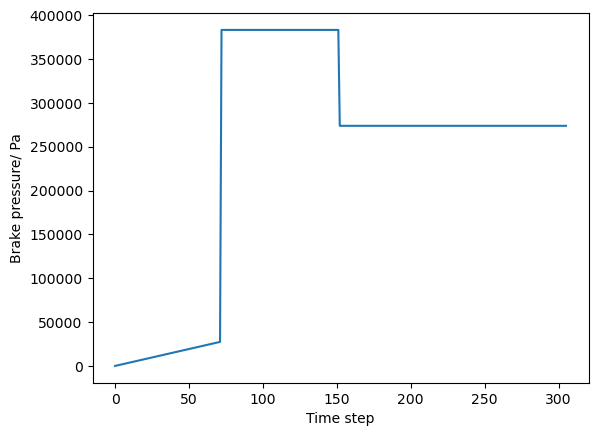

In [1]:
import dolfinx
# import basic
import pyvista, ufl, dolfinx, time, sys, os, shutil
import numpy as np
import matplotlib.pyplot as plt

# import speciail library
from dolfinx.fem.petsc import (  LinearProblem,  assemble_vector,    assemble_matrix,
      create_vector,    apply_lifting,    set_bc,)
from dolfinx import fem, mesh, io, plot, default_scalar_type, nls, log
from dolfinx.fem import (    Constant,    dirichletbc,    Function,   FunctionSpace,
     form,    locate_dofs_topological,)
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import locate_entities, locate_entities_boundary, meshtags
from ufl import (    SpatialCoordinate,    TestFunction,    TrialFunction,
     dx,    grad,    inner,    Measure,    dot,    FacetNormal,)
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from petsc4py import PETSc
from mpi4py import MPI

# calculate how long time the simulation it is
start_time = time.time()
# mesh-size, contact area coefficient
mesh_min = 3
mesh_max = 3
c_contact = 1
# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r = 448
v_vehicle = 160
c_acc = 1

def vehicle_initial(angular_r, v_vehicle, c_contact, c_acc):
    import numpy as np
    # v_ini  =  raad/ss
    v_ini = v_vehicle/3.6   /   (920/2/1000) 
    # D_wheel = 920 mm, v = D_wheel /2 /1000 * v_ini *3.6   # km/h
    # Start time, Final time  
    t = 0
    t_brake = 49
    t_lag1 = 6
    t_lag2 = 8
    # rubbing element radius, Contact area 
    r_rub = 18.8
    S_rub_circle = r_rub**2 * c_contact
    S_total = S_rub_circle * np.pi * 18  #mm2
    # initial and brake pad temperature
    Ti = 60
    Tm = 60
    # density (kg.m^-3), capacity (J/Kg.K), conductivity (W/m.K)
    t_u = 1e3 # m to mm
    rho = 7850 /(t_u**3)
    c = 462
    k = 48 / t_u
    # mu, P_brake,  r_disc , heat_distribution  
    mu = 0.376
    P_initial = 274000
    r_disc = 0.25
    heat_distribution = 0.88
    # calculate total num_steps
    if c_acc == 1:  # constant acc for the whole process
        acc = v_ini/t_brake
        # end velocity, km/h
        v_lag_end1 = (v_ini - (acc *t_lag1) )  
        v_lag_end2 = (v_ini - (acc *(t_lag1+t_lag2) ) )
        # angular speed, rad/s
        angular_r_rad = angular_r / 180 *np.pi  
        # lag time for period 1 and 2
        dt_lag1 = angular_r_rad  /  ( ( v_ini + v_lag_end1  ) /2 )
        dt_lag2 = angular_r_rad  /  ( ( v_lag_end1 + v_lag_end2  ) /2 )
        # lag steps for period 1 and 2
        n_lag1 = round (t_lag1 / dt_lag1) + 1 
        n_lag2 = round (t_lag2 / dt_lag2) + 1
        # every second, the rotation angular divide average speed, then know the average dt.
        dt_a_lag2 = angular_r_rad  /  ( v_lag_end2 /2 )     
        n_a_lag =  round ( (t_brake - t_lag1 - t_lag2) / dt_a_lag2 )+ 1     
        num_steps = n_lag1 + n_lag2 + n_a_lag
        
        dt = []
        v_angular = [v_ini]
        for i in range(num_steps):
            dt.append ( angular_r_rad / v_angular[i] )
            v_angular.append (  v_ini- sum(dt) * acc )           
        P = []
        
        for i in range(num_steps):
            if i <= n_lag1:
                # linear pressure increase * 10%
               P.append( P_initial/ n_lag1 * (i * 0.1) )
            elif n_lag1 < i <= (n_lag1 + n_lag2):
                # heat lost in lag1 is added on lag2, 50%, should be 90% here
               P.append( P_initial * (1+ n_lag1 / (2 * n_lag2)* 0.9 ) ) 
            else:
                P.append( P_initial) 
            
          
    # S_or is the original brake pad rubbing area, 200 cm2. 
    S_or = 200
    S_new = S_total/100 #mm2 to cm2
    g = []
    for i in range(num_steps):
        g.append ( mu * P[i] * v_angular[i] * r_disc * heat_distribution *2 /(t_u**2)  * (S_or/S_new) )
    h = 7.75e-5
    radiation = 5.670*(10e-8)/(t_u**2)  * 0.64
    return dt,P,g,num_steps,h,radiation,v_angular,Ti,Tm,S_rub_circle,t,rho,c,k,t_brake,S_total,n_lag1,n_lag2,n_a_lag   
# calling local functions to get all parameters
( dt,P,g,num_steps,h,radiation,v_angular,Ti,Tm,S_rub_circle,t,rho,c, k, t_brake,S_total,n_lag1,n_lag2,n_a_lag) = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)

del dt[-1] 
num_steps = num_steps -1

print("1: Total tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)

plt.plot(P)
plt.xlabel("Time step")  # Label for x-axis
plt.ylabel("Brake pressure/ Pa")  # Label for y-axis


71
80
155
305


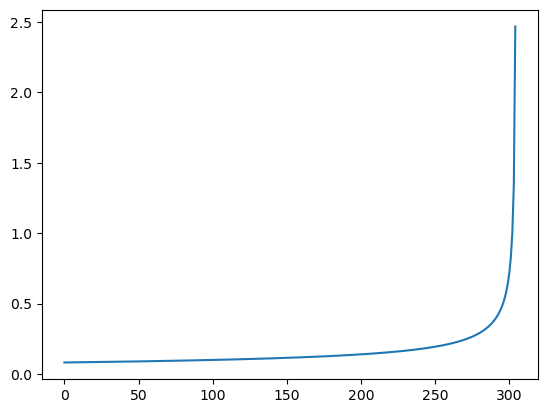

In [2]:
print(n_lag1)
print(n_lag2)
print(n_a_lag)
from disc_f import *
print(len(dt) )
plt.plot(dt)


In [3]:
print (  (n_lag1+n_lag2)  )

151


## 2: Mesh

In [4]:
######################################  mesh  ###################################3
mesh_name = f"{mesh_min}-{mesh_max}"
mesh_filename1 = "m-{}.msh".format(mesh_name)
mesh_filename2 = "m-{}".format(mesh_name)

if os.path.exists(mesh_filename1):
    # Run this command if the file exists
    print(f"The file '{mesh_filename1}' exists, start creat now:")
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

else:
    # Run this command if the file does not exist
    print(f"The file '{mesh_filename1}' does not exist, start building:")
    mesh_brake_disc(mesh_min, mesh_max, mesh_filename2, 'tetr')
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

# Define variational problem, CG is Lagrabge
V = fem.functionspace(domain, ("CG", 1))


# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs=[])
    return problem.solve()


# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V, DG is discontinuous Lagrange
Q = fem.functionspace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init, V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[2], 50))
bc = fem.dirichletbc(
    PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V
)
np.set_printoptions(threshold=np.inf)

import meshio

mesh1 = meshio.read(mesh_filename1)
total_elements = sum(len(cells.data) for cells in mesh1.cells)

The file 'm-3-3.msh' exists, start creat now:
Info    : Reading 'm-3-3.msh'...
Info    : 168 entities
Info    : 225961 nodes
Info    : 1184080 elements                                              
Info    : Done reading 'm-3-3.msh'                                         



## 3: Setup 


In [5]:
# create xdmf file, for paraview
xdmf_name = "T-s-{}-d-{}-{}-c-{}-e-{}.xdmf".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
h5_name = "T-s-{}-d-{}-{}-c-{}-e-{}.h5".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
xdmf = io.XDMFFile(domain.comm, xdmf_name, "w")
xdmf.write_mesh(domain)

# Create boundary condition
x_co, y_co = get_rub_coordinate()

common_indices3, facet_markers3, sorted_indices3 = target_facets(
    domain, x_co, y_co, S_rub_circle
)

facet_tag = meshtags(
    domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
)
ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

## 4: Variational equation


In [6]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init, V)
t = 0
xdmf.write_function(uh, t)

# u = trial function, solution what we want to know
u = fem.Function(V)

v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n_vector = FacetNormal(domain)

F = (     (rho * c) / dt[0] * inner(u, v) * dx
    + k * inner(grad(u), grad(v)) * dx
    + h * inner(u, v) * ds(200)
    + radiation * inner(u**4, v) * ds(200)
    - (  inner(f, v) * dx
        + (rho * c) / dt[0] * inner(u_n, v) * dx
        + h * Tm * v * ds(200)
        + radiation * (Tm**4) * v * ds(200)   )  )


for i in list(range(1, 19)):
    # before 2024/5/16
    #F += -k * dot(grad(u) * v, n_vector) * ds(10 * i) - inner(g[0], v) * ds(10 * i)
    ## new start 2024/5/16, friction points do not have convection heat + heat input
    F += (  + inner(g[0], v) * ds(10 * i) 
          - h * inner( u, v) * ds(10 * i)  
          - radiation * inner( (u**4 - Tm**4), v) * ds(10 * i)   )

problem = NonlinearProblem(F, u, bcs=[bc])

## 7: Using petsc4py to create a linear solver
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(u)
assert converged


## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl

pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()

gif_name = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements)

plotter.open_gif(gif_name, fps=30)
grid.point_data["Temperature"] = u.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(
    title_font_size=25,
    label_font_size=20,
    color="black",
    position_x=0.1,
    position_y=0.8,
    width=0.8,
    height=0.1,
)
renderer = plotter.add_mesh(
    warped,
    show_edges=True,
    lighting=False,
    cmap=viridis,
    scalar_bar_args=sargs,
    # clim=[0, max(uh.x.array)])
    clim=[0, 200],
)

2024-10-01 17:55:18.158 (  20.115s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:55:20.185 (  22.142s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:55:20.909 (  22.866s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.136219 (tol = 1e-10) r (rel) = 4.77593e-06(tol = 1e-06)
2024-10-01 17:55:21.657 (  23.614s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:55:22.289 (  24.246s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.5183e-07 (tol = 1e-10) r (rel) = 2.63597e-11(tol = 1e-06)
2024-10-01 17:55:22.289 (  24.246s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.


## 5: Solution


In [7]:
T_array = [(0, [Ti for _ in range(len(u.x.array))])]
total_degree = 0

for i in range(num_steps):
    t += dt[i]

    x_co, y_co = rub_rotation(x_co, y_co, angular_r)  # update the location
    total_degree += angular_r  # Incrementing degree by 10 in each step

    sys.stdout.write("\r1: Rotation has applied for {} degree. ".format(total_degree))
    sys.stdout.write("2: Current time is " + str(round(t, 1)) + " s. ")
    sys.stdout.write("3: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    common_indices3, facet_markers3, sorted_indices3 = target_facets(
        domain, x_co, y_co, S_rub_circle
    )
    facet_tag = meshtags(
        domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
    )
    ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

    F = (
        (rho * c) / dt[i] * inner(u, v) * dx
        + k * inner(grad(u), grad(v)) * dx
        + h * inner(u, v) * ds(200)
        + radiation * inner(u**4, v) * ds(200)
        - (
            inner(f, v) * dx
            + (rho * c) / dt[i] * inner(u_n, v) * dx
            + h * Tm * v * ds(200)
            + radiation * (Tm**4) * v * ds(200)
        )
    )

    for j in list(range(1, 19)):
        #F += -k * dot(grad(u) * v, n_vector) * ds(10 * j) - inner(g[i], v) * ds(10 * j)
        F += ( 
          - inner(g[i], v) * ds(10 * j) 
          - h * inner( u, v) * ds(10 * j)  
          - radiation * inner( (u**4 - Tm**4), v) * ds(10 * j) 
         )

        

    problem = NonlinearProblem(F, u, bcs=[bc])

    ## 7: Using petsc4py to create a linear solver
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-6

    # Solver parameters
    #solver.convergence_criterion = "residual"  # Switch to residual criterion
    #solver.rtol = 1e-5  # Relax the relative tolerance
    #solver.atol = 1e-8  # Set an absolute tolerance (optional)
    #solver.max_it = 50  # Increase max iterations
    #solver.relaxation_parameter = 0.8  # Apply damping to Newton update
    #solver.report = True

    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "cg"
    opts[f"{option_prefix}pc_type"] = "gamg"
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    ksp.setFromOptions()

    sys.stdout.write("1: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    solver.solve(u)
    u.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = u.x.array

    T_array.append((t, u.x.array.copy()))
    # Write solution to file
    xdmf.write_function(u, t)
    # Update plot
    # warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(u.x.array, render=False)
    plotter.write_frame()

plotter.close()
xdmf.close()
print()

csv_name = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
save_t_T(csv_name, T_array)

1: Rotation has applied for 448 degree. 2: Current time is 0.1 s. 3: Completion is 0.2 %. 

2024-10-01 17:55:25.599 (  27.556s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:25.615 (  27.572s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:25.615 (  27.572s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:55:25.644 (  27.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:25.656 (  27.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:25.656 (  27.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:55:25.660 (  27.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:25.671 (  27.628s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.2 %. 

2024-10-01 17:55:29.304 (  31.260s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:55:31.419 (  33.376s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:55:32.053 (  34.010s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 2.06742e-05 (tol = 1e-10) r (rel) = 3.57668e-06(tol = 1e-06)
2024-10-01 17:55:32.764 (  34.721s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:55:33.326 (  35.283s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.53464e-10 (tol = 1e-10) r (rel) = 2.65496e-11(tol = 1e-06)
2024-10-01 17:55:33.326 (  35.283s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 17:55:33.326 (  35.283s) [main            ]      xdmf_fun

1: Rotation has applied for 896 degree. 2: Current time is 0.2 s. 3: Completion is 0.3 %. 

2024-10-01 17:55:33.997 (  35.954s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:34.010 (  35.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:34.010 (  35.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:55:34.016 (  35.972s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:34.022 (  35.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:34.022 (  35.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:55:34.026 (  35.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:34.033 (  35.990s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.3 %. 

2024-10-01 17:55:37.896 (  39.853s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:55:40.001 (  41.958s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:55:40.634 (  42.591s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 2.58942e-05 (tol = 1e-10) r (rel) = 3.40406e-06(tol = 1e-06)
2024-10-01 17:55:41.309 (  43.266s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:55:41.923 (  43.880s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.94536e-10 (tol = 1e-10) r (rel) = 2.55738e-11(tol = 1e-06)
2024-10-01 17:55:41.923 (  43.880s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 17:55:41.923 (  43.880s) [main            ]      xdmf_fun

1: Rotation has applied for 1344 degree. 2: Current time is 0.2 s. 3: Completion is 0.5 %. 

2024-10-01 17:55:42.389 (  44.346s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:42.397 (  44.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:42.397 (  44.354s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:55:42.403 (  44.360s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:42.408 (  44.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:42.409 (  44.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:55:42.413 (  44.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:42.419 (  44.376s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.5 %. 

2024-10-01 17:55:44.776 (  46.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:55:44.776 (  46.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:55:44.792 (  46.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:55:44.792 (  46.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:55:44.868 (  46.824s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:55:45.396 (  47.353s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:55:46.363 (  48.320s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:55:48.588 (  50.545s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1792 degree. 2: Current time is 0.3 s. 3: Completion is 0.7 %. 

2024-10-01 17:55:51.003 (  52.960s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:51.012 (  52.969s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:51.012 (  52.969s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:55:51.017 (  52.974s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:51.024 (  52.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:51.026 (  52.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:55:51.030 (  52.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:51.036 (  52.993s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.7 %. 

2024-10-01 17:55:55.310 (  57.267s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:55:57.454 (  59.410s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:55:58.084 (  60.041s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 7.66296e-05 (tol = 1e-10) r (rel) = 3.54932e-06(tol = 1e-06)
2024-10-01 17:55:58.725 (  60.682s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:55:59.334 (  61.291s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.76115e-10 (tol = 1e-10) r (rel) = 2.66844e-11(tol = 1e-06)
2024-10-01 17:55:59.334 (  61.291s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 17:55:59.335 (  61.292s) [main            ]      xdmf_fun

1: Rotation has applied for 2240 degree. 2: Current time is 0.4 s. 3: Completion is 0.8 %. 

2024-10-01 17:55:59.793 (  61.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:59.808 (  61.765s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:59.808 (  61.765s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:55:59.812 (  61.769s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:59.819 (  61.776s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:59.819 (  61.776s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:55:59.824 (  61.781s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:55:59.830 (  61.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.8 %. 

2024-10-01 17:56:01.946 (  63.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:56:01.946 (  63.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:56:02.012 (  63.969s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:56:02.457 (  64.414s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:56:03.268 (  65.225s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:05.206 (  67.163s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:05.791 (  67.748s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 7.69642e-05 (tol = 1e-10) r (rel) = 3.53051e-06(tol = 1e-06)
2024-10-01 17:56:06.402 (  68.359

1: Rotation has applied for 2688 degree. 2: Current time is 0.5 s. 3: Completion is 1.0 %. 

2024-10-01 17:56:07.412 (  69.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:07.421 (  69.377s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:07.421 (  69.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:56:07.425 (  69.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:07.434 (  69.391s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:07.435 (  69.392s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:56:07.440 (  69.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:07.446 (  69.402s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.0 %. 

2024-10-01 17:56:09.823 (  71.780s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:56:09.823 (  71.780s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:56:09.841 (  71.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:56:09.841 (  71.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:56:09.918 (  71.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:56:10.421 (  72.378s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:56:11.359 (  73.316s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:13.550 (  75.506s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3136 degree. 2: Current time is 0.6 s. 3: Completion is 1.2 %. 

2024-10-01 17:56:15.946 (  77.903s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:15.955 (  77.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:15.955 (  77.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:56:15.960 (  77.917s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:15.968 (  77.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:15.970 (  77.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:56:15.974 (  77.931s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:15.980 (  77.936s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.2 %. 

2024-10-01 17:56:19.891 (  81.848s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:22.097 (  84.054s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:22.700 (  84.657s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000102775 (tol = 1e-10) r (rel) = 3.40222e-06(tol = 1e-06)
2024-10-01 17:56:23.419 (  85.376s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:24.072 (  86.029s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.67464e-10 (tol = 1e-10) r (rel) = 2.54058e-11(tol = 1e-06)
2024-10-01 17:56:24.072 (  86.029s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 17:56:24.074 (  86.030s) [main            ]      xdmf_fun

1: Rotation has applied for 3584 degree. 2: Current time is 0.7 s. 3: Completion is 1.3 %. 

2024-10-01 17:56:24.545 (  86.502s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:24.556 (  86.512s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:24.556 (  86.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:56:24.562 (  86.518s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:24.569 (  86.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:24.569 (  86.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:56:24.574 (  86.530s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:24.580 (  86.536s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.3 %. 

2024-10-01 17:56:27.369 (  89.325s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:56:27.880 (  89.837s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:56:28.806 (  90.763s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:30.977 (  92.934s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:31.577 (  93.534s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000156599 (tol = 1e-10) r (rel) = 3.59861e-06(tol = 1e-06)
2024-10-01 17:56:32.304 (  94.261s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:33.030 (  94.987s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.18722e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 4032 degree. 2: Current time is 0.7 s. 3: Completion is 1.5 %. 

2024-10-01 17:56:33.499 (  95.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:33.507 (  95.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:33.507 (  95.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:56:33.512 (  95.468s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:33.518 (  95.475s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:33.518 (  95.475s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:56:33.523 (  95.480s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:33.529 (  95.486s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.5 %. 

2024-10-01 17:56:37.493 (  99.450s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:39.646 ( 101.603s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:40.279 ( 102.235s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000150416 (tol = 1e-10) r (rel) = 3.59911e-06(tol = 1e-06)
2024-10-01 17:56:40.985 ( 102.942s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:41.554 ( 103.511s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.13769e-09 (tol = 1e-10) r (rel) = 2.72223e-11(tol = 1e-06)
2024-10-01 17:56:41.554 ( 103.511s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 17:56:41.555 ( 103.511s) [main            ]      xdmf_fun

1: Rotation has applied for 4480 degree. 2: Current time is 0.8 s. 3: Completion is 1.7 %. 

2024-10-01 17:56:42.011 ( 103.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:42.021 ( 103.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:42.021 ( 103.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:56:42.028 ( 103.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:42.034 ( 103.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:42.034 ( 103.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:56:42.040 ( 103.996s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:42.045 ( 104.002s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.7 %. 

2024-10-01 17:56:44.458 ( 106.415s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:56:44.964 ( 106.921s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:56:45.886 ( 107.843s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:48.039 ( 109.995s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:48.669 ( 110.625s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000153503 (tol = 1e-10) r (rel) = 3.49164e-06(tol = 1e-06)
2024-10-01 17:56:49.308 ( 111.265s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:49.969 ( 111.926s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.16613e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 4928 degree. 2: Current time is 0.9 s. 3: Completion is 1.8 %. 

2024-10-01 17:56:50.470 ( 112.426s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:50.477 ( 112.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:50.477 ( 112.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:56:50.482 ( 112.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:50.491 ( 112.448s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:50.491 ( 112.448s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:56:50.496 ( 112.453s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:50.502 ( 112.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.8 %. 

2024-10-01 17:56:54.443 ( 116.399s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:56.681 ( 118.638s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:57.296 ( 119.252s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000161202 (tol = 1e-10) r (rel) = 3.35864e-06(tol = 1e-06)
2024-10-01 17:56:58.060 ( 120.017s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:56:58.726 ( 120.683s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.1922e-09 (tol = 1e-10) r (rel) = 2.48393e-11(tol = 1e-06)
2024-10-01 17:56:58.726 ( 120.683s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 17:56:58.727 ( 120.685s) [main            ]      xdmf_func

1: Rotation has applied for 5376 degree. 2: Current time is 1.0 s. 3: Completion is 2.0 %. 

2024-10-01 17:56:59.237 ( 121.195s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:59.246 ( 121.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:59.247 ( 121.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:56:59.251 ( 121.208s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:59.259 ( 121.215s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:59.259 ( 121.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:56:59.264 ( 121.220s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:56:59.270 ( 121.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 2.0 %. 

2024-10-01 17:57:02.062 ( 124.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:57:02.584 ( 124.541s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:57:03.559 ( 125.516s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:05.865 ( 127.822s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:06.512 ( 128.469s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000227892 (tol = 1e-10) r (rel) = 3.59776e-06(tol = 1e-06)
2024-10-01 17:57:07.261 ( 129.218s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:07.901 ( 129.858s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.72877e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 5824 degree. 2: Current time is 1.1 s. 3: Completion is 2.2 %. 

2024-10-01 17:57:08.410 ( 130.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:08.421 ( 130.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:08.422 ( 130.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:57:08.428 ( 130.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:08.437 ( 130.394s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:08.438 ( 130.394s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:57:08.443 ( 130.400s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:08.451 ( 130.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 2.2 %. 

2024-10-01 17:57:11.263 ( 133.220s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:57:11.806 ( 133.763s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:57:12.742 ( 134.699s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:14.851 ( 136.807s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:15.436 ( 137.393s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000228774 (tol = 1e-10) r (rel) = 3.63597e-06(tol = 1e-06)
2024-10-01 17:57:16.150 ( 138.107s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:16.728 ( 138.685s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.74792e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 6272 degree. 2: Current time is 1.1 s. 3: Completion is 2.3 %. 

2024-10-01 17:57:17.197 ( 139.154s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:17.204 ( 139.161s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:17.204 ( 139.161s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:57:17.209 ( 139.165s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:17.215 ( 139.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:17.215 ( 139.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:57:17.220 ( 139.177s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:17.228 ( 139.185s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 2.3 %. 

2024-10-01 17:57:19.589 ( 141.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:57:20.083 ( 142.040s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:57:21.000 ( 142.957s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:23.155 ( 145.112s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:23.765 ( 145.722s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000218479 (tol = 1e-10) r (rel) = 3.51112e-06(tol = 1e-06)
2024-10-01 17:57:24.454 ( 146.410s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:25.046 ( 147.003s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.65005e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 6720 degree. 2: Current time is 1.2 s. 3: Completion is 2.5 %. 

2024-10-01 17:57:25.534 ( 147.491s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:25.541 ( 147.498s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:25.541 ( 147.498s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:57:25.550 ( 147.506s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:25.555 ( 147.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:25.556 ( 147.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:57:25.561 ( 147.517s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:25.568 ( 147.525s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 2.5 %. 

2024-10-01 17:57:27.942 ( 149.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:57:28.445 ( 150.402s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:57:29.407 ( 151.364s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:31.582 ( 153.539s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:32.185 ( 154.142s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00022647 (tol = 1e-10) r (rel) = 3.42829e-06(tol = 1e-06)
2024-10-01 17:57:32.880 ( 154.837s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:33.472 ( 155.429s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.68091e-09 (tol = 1e-10) r (rel) 

1: Rotation has applied for 7168 degree. 2: Current time is 1.3 s. 3: Completion is 2.7 %. 

2024-10-01 17:57:33.946 ( 155.903s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:33.955 ( 155.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:33.955 ( 155.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:57:33.959 ( 155.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:33.967 ( 155.924s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:33.967 ( 155.924s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:57:33.972 ( 155.929s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:33.980 ( 155.937s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 2.7 %. 

2024-10-01 17:57:36.501 ( 158.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:57:36.501 ( 158.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:57:36.518 ( 158.475s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:57:36.518 ( 158.475s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:57:36.594 ( 158.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:57:37.106 ( 159.063s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:57:38.031 ( 159.988s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:40.149 ( 162.106s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 7616 degree. 2: Current time is 1.4 s. 3: Completion is 2.8 %. 

2024-10-01 17:57:42.448 ( 164.404s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:42.460 ( 164.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:42.460 ( 164.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:57:42.465 ( 164.422s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:42.471 ( 164.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:42.471 ( 164.428s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:57:42.476 ( 164.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:42.484 ( 164.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 2.8 %. 

2024-10-01 17:57:46.409 ( 168.366s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:48.564 ( 170.521s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:49.225 ( 171.182s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000300606 (tol = 1e-10) r (rel) = 3.56546e-06(tol = 1e-06)
2024-10-01 17:57:49.905 ( 171.862s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:50.471 ( 172.428s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.27543e-09 (tol = 1e-10) r (rel) = 2.69887e-11(tol = 1e-06)
2024-10-01 17:57:50.472 ( 172.428s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 17:57:50.472 ( 172.429s) [main            ]      xdmf_fun

1: Rotation has applied for 8064 degree. 2: Current time is 1.5 s. 3: Completion is 3.0 %. 

2024-10-01 17:57:50.933 ( 172.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:50.942 ( 172.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:50.942 ( 172.899s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:57:50.948 ( 172.904s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:50.953 ( 172.910s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:50.954 ( 172.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:57:50.959 ( 172.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:50.965 ( 172.922s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 3.0 %. 

2024-10-01 17:57:53.340 ( 175.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:57:53.853 ( 175.810s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:57:54.768 ( 176.725s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:56.914 ( 178.871s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:57.513 ( 179.469s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00028681 (tol = 1e-10) r (rel) = 3.54118e-06(tol = 1e-06)
2024-10-01 17:57:58.278 ( 180.235s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:57:58.875 ( 180.832s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.16644e-09 (tol = 1e-10) r (rel) 

1: Rotation has applied for 8512 degree. 2: Current time is 1.6 s. 3: Completion is 3.2 %. 

2024-10-01 17:57:59.394 ( 181.351s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:59.402 ( 181.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:59.402 ( 181.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:57:59.406 ( 181.363s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:59.416 ( 181.373s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:59.416 ( 181.373s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:57:59.420 ( 181.377s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:57:59.428 ( 181.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 3.2 %. 

2024-10-01 17:58:01.743 ( 183.700s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:58:01.743 ( 183.700s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:58:01.760 ( 183.717s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:58:01.760 ( 183.717s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:58:01.829 ( 183.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:58:02.329 ( 184.286s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:58:03.246 ( 185.202s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:05.565 ( 187.521s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8960 degree. 2: Current time is 1.6 s. 3: Completion is 3.4 %. 

2024-10-01 17:58:07.990 ( 189.947s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:08.001 ( 189.958s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:08.001 ( 189.958s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:58:08.006 ( 189.963s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:08.013 ( 189.969s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:08.013 ( 189.969s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:58:08.017 ( 189.974s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:08.023 ( 189.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 3.4 %. 

2024-10-01 17:58:10.664 ( 192.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:58:11.183 ( 193.140s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:58:12.113 ( 194.070s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:14.305 ( 196.262s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:14.871 ( 196.828s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000361542 (tol = 1e-10) r (rel) = 3.57654e-06(tol = 1e-06)
2024-10-01 17:58:15.583 ( 197.540s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:16.151 ( 198.108s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.7339e-09 (tol = 1e-10) r (rel) 

1: Rotation has applied for 9408 degree. 2: Current time is 1.7 s. 3: Completion is 3.5 %. 

2024-10-01 17:58:16.616 ( 198.573s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:16.623 ( 198.579s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:16.623 ( 198.579s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:58:16.627 ( 198.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:16.636 ( 198.593s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:16.636 ( 198.593s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:58:16.641 ( 198.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:16.646 ( 198.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 3.5 %. 

2024-10-01 17:58:19.123 ( 201.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:58:19.646 ( 201.603s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:58:20.574 ( 202.531s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:22.732 ( 204.689s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:23.382 ( 205.338s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000370594 (tol = 1e-10) r (rel) = 3.57873e-06(tol = 1e-06)
2024-10-01 17:58:24.094 ( 206.051s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:24.925 ( 206.882s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.81985e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 9856 degree. 2: Current time is 1.8 s. 3: Completion is 3.7 %. 

2024-10-01 17:58:25.338 ( 207.294s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:25.347 ( 207.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:25.347 ( 207.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:58:25.353 ( 207.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:25.361 ( 207.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:25.361 ( 207.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:58:25.365 ( 207.322s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:25.371 ( 207.328s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 3.7 %. 

2024-10-01 17:58:27.614 ( 209.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:58:27.614 ( 209.571s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:58:27.631 ( 209.588s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:58:27.631 ( 209.588s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:58:27.708 ( 209.664s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:58:28.237 ( 210.194s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:58:29.148 ( 211.105s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:31.295 ( 213.252s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 10304 degree. 2: Current time is 1.9 s. 3: Completion is 3.9 %. 

2024-10-01 17:58:33.536 ( 215.492s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:33.547 ( 215.504s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:33.547 ( 215.504s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:58:33.552 ( 215.509s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:33.557 ( 215.514s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:33.557 ( 215.514s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:58:33.562 ( 215.519s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:33.569 ( 215.525s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 3.9 %. 

2024-10-01 17:58:37.265 ( 219.223s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:39.247 ( 221.204s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:39.848 ( 221.805s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000357249 (tol = 1e-10) r (rel) = 3.5076e-06(tol = 1e-06)
2024-10-01 17:58:40.489 ( 222.446s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:41.055 ( 223.012s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.6862e-09 (tol = 1e-10) r (rel) = 2.63741e-11(tol = 1e-06)
2024-10-01 17:58:41.055 ( 223.012s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 17:58:41.056 ( 223.013s) [main            ]      xdmf_funct

1: Rotation has applied for 10752 degree. 2: Current time is 2.0 s. 3: Completion is 4.0 %. 

2024-10-01 17:58:41.538 ( 223.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:41.546 ( 223.503s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:41.546 ( 223.503s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:58:41.552 ( 223.508s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:41.558 ( 223.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:41.558 ( 223.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:58:41.563 ( 223.519s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:41.570 ( 223.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 4.0 %. 

2024-10-01 17:58:44.006 ( 225.963s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:58:44.007 ( 225.963s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:58:44.078 ( 226.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:58:44.592 ( 226.548s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:58:45.541 ( 227.499s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:47.690 ( 229.647s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:48.289 ( 230.246s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000413865 (tol = 1e-10) r (rel) = 3.55282e-06(tol = 1e-06)
2024-10-01 17:58:48.985 ( 230.942

1: Rotation has applied for 11200 degree. 2: Current time is 2.1 s. 3: Completion is 4.2 %. 

2024-10-01 17:58:50.070 ( 232.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:50.077 ( 232.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:50.078 ( 232.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:58:50.083 ( 232.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:50.089 ( 232.046s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:50.090 ( 232.046s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:58:50.094 ( 232.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:50.100 ( 232.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 4.2 %. 

2024-10-01 17:58:53.580 ( 235.537s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:55.614 ( 237.571s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:56.150 ( 238.107s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000464933 (tol = 1e-10) r (rel) = 3.61604e-06(tol = 1e-06)
2024-10-01 17:58:56.770 ( 238.726s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:58:57.726 ( 239.682s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.57554e-09 (tol = 1e-10) r (rel) = 2.7809e-11(tol = 1e-06)
2024-10-01 17:58:57.726 ( 239.682s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 17:58:57.726 ( 239.683s) [main            ]      xdmf_func

1: Rotation has applied for 11648 degree. 2: Current time is 2.1 s. 3: Completion is 4.4 %. 

2024-10-01 17:58:58.152 ( 240.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:58.159 ( 240.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:58.159 ( 240.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:58:58.163 ( 240.120s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:58.172 ( 240.129s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:58.172 ( 240.129s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:58:58.176 ( 240.133s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:58:58.182 ( 240.139s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 4.4 %. 

2024-10-01 17:59:01.511 ( 243.468s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:03.648 ( 245.605s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:04.227 ( 246.184s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000430561 (tol = 1e-10) r (rel) = 3.64212e-06(tol = 1e-06)
2024-10-01 17:59:04.935 ( 246.891s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:05.502 ( 247.459s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.26959e-09 (tol = 1e-10) r (rel) = 2.76574e-11(tol = 1e-06)
2024-10-01 17:59:05.502 ( 247.459s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 17:59:05.502 ( 247.459s) [main            ]      xdmf_fun

1: Rotation has applied for 12096 degree. 2: Current time is 2.2 s. 3: Completion is 4.6 %. 

2024-10-01 17:59:05.949 ( 247.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:05.958 ( 247.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:05.958 ( 247.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:59:05.963 ( 247.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:05.970 ( 247.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:05.970 ( 247.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:59:05.974 ( 247.931s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:05.979 ( 247.936s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 4.6 %. 

2024-10-01 17:59:08.297 ( 250.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:59:08.784 ( 250.740s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:59:09.673 ( 251.630s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:11.792 ( 253.749s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:12.466 ( 254.423s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000422582 (tol = 1e-10) r (rel) = 3.52491e-06(tol = 1e-06)
2024-10-01 17:59:13.183 ( 255.140s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:13.805 ( 255.762s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.22171e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 12544 degree. 2: Current time is 2.3 s. 3: Completion is 4.7 %. 

2024-10-01 17:59:14.325 ( 256.282s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:14.334 ( 256.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:14.334 ( 256.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:59:14.339 ( 256.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:14.346 ( 256.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:14.346 ( 256.303s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:59:14.350 ( 256.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:14.358 ( 256.314s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 4.7 %. 

2024-10-01 17:59:18.301 ( 260.258s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:20.457 ( 262.414s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:21.029 ( 262.986s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000490866 (tol = 1e-10) r (rel) = 3.61313e-06(tol = 1e-06)
2024-10-01 17:59:21.733 ( 263.689s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:22.342 ( 264.299s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.74963e-09 (tol = 1e-10) r (rel) = 2.76001e-11(tol = 1e-06)
2024-10-01 17:59:22.342 ( 264.299s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 17:59:22.342 ( 264.299s) [main            ]      xdmf_fun

1: Rotation has applied for 12992 degree. 2: Current time is 2.4 s. 3: Completion is 4.9 %. 

2024-10-01 17:59:22.819 ( 264.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:22.826 ( 264.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:22.827 ( 264.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:59:22.831 ( 264.787s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:22.837 ( 264.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:22.838 ( 264.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:59:22.842 ( 264.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:22.849 ( 264.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 4.9 %. 

2024-10-01 17:59:25.455 ( 267.412s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:59:25.456 ( 267.412s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:59:25.472 ( 267.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:59:25.472 ( 267.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:59:25.544 ( 267.500s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:59:26.025 ( 267.982s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:59:26.917 ( 268.873s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:28.985 ( 270.942s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 13440 degree. 2: Current time is 2.5 s. 3: Completion is 5.1 %. 

2024-10-01 17:59:31.303 ( 273.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:31.311 ( 273.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:31.311 ( 273.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:59:31.316 ( 273.273s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:31.321 ( 273.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:31.322 ( 273.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:59:31.326 ( 273.283s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:31.332 ( 273.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 5.1 %. 

2024-10-01 17:59:35.035 ( 276.991s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:37.116 ( 279.073s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:37.706 ( 279.663s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000500123 (tol = 1e-10) r (rel) = 3.6609e-06(tol = 1e-06)
2024-10-01 17:59:38.382 ( 280.339s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:38.949 ( 280.905s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.79568e-09 (tol = 1e-10) r (rel) = 2.77844e-11(tol = 1e-06)
2024-10-01 17:59:38.949 ( 280.906s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 17:59:38.950 ( 280.906s) [main            ]      xdmf_func

1: Rotation has applied for 13888 degree. 2: Current time is 2.6 s. 3: Completion is 5.3 %. 

2024-10-01 17:59:39.403 ( 281.360s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:39.413 ( 281.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:39.413 ( 281.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:59:39.418 ( 281.374s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:39.424 ( 281.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:39.424 ( 281.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:59:39.428 ( 281.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:39.436 ( 281.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 5.3 %. 

2024-10-01 17:59:43.224 ( 285.181s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:45.312 ( 287.269s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:45.884 ( 287.841s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000480608 (tol = 1e-10) r (rel) = 3.49624e-06(tol = 1e-06)
2024-10-01 17:59:46.573 ( 288.530s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:47.168 ( 289.125s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 3.63862e-09 (tol = 1e-10) r (rel) = 2.64696e-11(tol = 1e-06)
2024-10-01 17:59:47.168 ( 289.125s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 17:59:47.169 ( 289.125s) [main            ]      xdmf_fun

1: Rotation has applied for 14336 degree. 2: Current time is 2.7 s. 3: Completion is 5.4 %. 

2024-10-01 17:59:47.642 ( 289.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:47.649 ( 289.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:47.649 ( 289.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:59:47.655 ( 289.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:47.661 ( 289.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:47.662 ( 289.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:59:47.665 ( 289.623s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:47.672 ( 289.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 5.4 %. 

2024-10-01 17:59:50.002 ( 291.958s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:59:50.002 ( 291.958s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:59:50.072 ( 292.029s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:59:50.559 ( 292.517s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 17:59:51.478 ( 293.435s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:53.618 ( 295.575s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 17:59:54.205 ( 296.162s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000535188 (tol = 1e-10) r (rel) = 3.54936e-06(tol = 1e-06)
2024-10-01 17:59:54.885 ( 296.842

1: Rotation has applied for 14784 degree. 2: Current time is 2.7 s. 3: Completion is 5.6 %. 

2024-10-01 17:59:55.965 ( 297.922s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:55.976 ( 297.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:55.976 ( 297.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:59:55.981 ( 297.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:55.992 ( 297.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:55.992 ( 297.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 17:59:55.996 ( 297.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 17:59:56.002 ( 297.959s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 5.6 %. 

2024-10-01 17:59:58.544 ( 300.501s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:59:58.544 ( 300.501s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 17:59:58.613 ( 300.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 17:59:59.091 ( 301.048s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:00:00.069 ( 302.026s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:02.217 ( 304.174s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:02.785 ( 304.742s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0006368 (tol = 1e-10) r (rel) = 3.62343e-06(tol = 1e-06)
2024-10-01 18:00:03.470 ( 305.427s)

1: Rotation has applied for 15232 degree. 2: Current time is 2.8 s. 3: Completion is 5.8 %. 

2024-10-01 18:00:04.538 ( 306.494s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:04.545 ( 306.502s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:04.546 ( 306.502s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:00:04.550 ( 306.507s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:04.558 ( 306.514s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:04.558 ( 306.514s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:00:04.562 ( 306.519s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:04.568 ( 306.525s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 5.8 %. 

2024-10-01 18:00:06.828 ( 308.785s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:00:06.829 ( 308.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:00:06.896 ( 308.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:00:07.386 ( 309.343s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:00:08.319 ( 310.276s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:10.476 ( 312.433s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:11.097 ( 313.054s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000570611 (tol = 1e-10) r (rel) = 3.67065e-06(tol = 1e-06)
2024-10-01 18:00:11.810 ( 313.767

1: Rotation has applied for 15680 degree. 2: Current time is 2.9 s. 3: Completion is 6.0 %. 

2024-10-01 18:00:12.858 ( 314.814s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:12.866 ( 314.823s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:12.866 ( 314.823s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:00:12.871 ( 314.828s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:12.878 ( 314.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:12.878 ( 314.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:00:12.882 ( 314.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:12.889 ( 314.845s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.0 %. 

2024-10-01 18:00:15.225 ( 317.182s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:00:15.751 ( 317.709s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:00:16.674 ( 318.631s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:18.799 ( 320.756s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:19.398 ( 321.355s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000558343 (tol = 1e-10) r (rel) = 3.59061e-06(tol = 1e-06)
2024-10-01 18:00:20.089 ( 322.046s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:20.841 ( 322.798s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.21549e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 16128 degree. 2: Current time is 3.0 s. 3: Completion is 6.1 %. 

2024-10-01 18:00:21.341 ( 323.298s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:21.349 ( 323.305s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:21.349 ( 323.305s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:00:21.353 ( 323.310s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:21.359 ( 323.316s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:21.359 ( 323.316s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:00:21.364 ( 323.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:21.370 ( 323.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.1 %. 

2024-10-01 18:00:23.705 ( 325.661s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:00:24.233 ( 326.189s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:00:25.150 ( 327.107s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:27.259 ( 329.216s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:27.887 ( 329.844s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000576375 (tol = 1e-10) r (rel) = 3.51005e-06(tol = 1e-06)
2024-10-01 18:00:28.592 ( 330.549s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:29.170 ( 331.127s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.37259e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 16576 degree. 2: Current time is 3.1 s. 3: Completion is 6.3 %. 

2024-10-01 18:00:29.625 ( 331.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:29.638 ( 331.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:29.638 ( 331.595s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:00:29.643 ( 331.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:29.649 ( 331.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:29.649 ( 331.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:00:29.654 ( 331.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:29.661 ( 331.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.3 %. 

2024-10-01 18:00:32.239 ( 334.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:00:32.239 ( 334.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:00:32.256 ( 334.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:00:32.256 ( 334.213s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:00:32.323 ( 334.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:00:32.832 ( 334.789s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:00:33.744 ( 335.701s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:35.985 ( 337.942s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17024 degree. 2: Current time is 3.2 s. 3: Completion is 6.5 %. 

2024-10-01 18:00:38.296 ( 340.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:38.303 ( 340.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:38.303 ( 340.260s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:00:38.309 ( 340.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:38.316 ( 340.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:38.316 ( 340.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:00:38.321 ( 340.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:38.327 ( 340.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.5 %. 

2024-10-01 18:00:41.668 ( 343.625s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:43.798 ( 345.755s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:44.495 ( 346.452s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000642878 (tol = 1e-10) r (rel) = 3.66634e-06(tol = 1e-06)
2024-10-01 18:00:45.080 ( 347.037s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:46.057 ( 348.014s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.90932e-09 (tol = 1e-10) r (rel) = 2.79979e-11(tol = 1e-06)
2024-10-01 18:00:46.058 ( 348.014s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:00:46.058 ( 348.015s) [main            ]      xdmf_fun

1: Rotation has applied for 17472 degree. 2: Current time is 3.3 s. 3: Completion is 6.7 %. 

2024-10-01 18:00:46.483 ( 348.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:46.495 ( 348.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:46.496 ( 348.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:00:46.500 ( 348.457s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:46.507 ( 348.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:46.507 ( 348.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:00:46.513 ( 348.470s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:46.520 ( 348.476s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.7 %. 

2024-10-01 18:00:48.847 ( 350.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:00:49.346 ( 351.303s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:00:50.251 ( 352.207s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:52.370 ( 354.327s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:52.947 ( 354.904s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000614985 (tol = 1e-10) r (rel) = 3.53708e-06(tol = 1e-06)
2024-10-01 18:00:53.625 ( 355.582s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:00:54.194 ( 356.151s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.66818e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 17920 degree. 2: Current time is 3.3 s. 3: Completion is 6.8 %. 

2024-10-01 18:00:54.665 ( 356.622s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:54.673 ( 356.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:54.673 ( 356.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:00:54.678 ( 356.635s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:54.683 ( 356.640s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:54.684 ( 356.640s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:00:54.688 ( 356.645s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:00:54.695 ( 356.651s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 6.8 %. 

2024-10-01 18:00:57.509 ( 359.466s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:00:58.440 ( 360.397s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:00.470 ( 362.427s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:01.154 ( 363.111s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000623417 (tol = 1e-10) r (rel) = 3.51427e-06(tol = 1e-06)
2024-10-01 18:01:01.794 ( 363.750s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:02.344 ( 364.301s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.72409e-09 (tol = 1e-10) r (rel) = 2.66302e-11(tol = 1e-06)
2024-10-01 18:01:02.344 ( 364.301s) [main            ]       NewtonSolver.cpp:252   INFO| Newton sol

1: Rotation has applied for 18368 degree. 2: Current time is 3.4 s. 3: Completion is 7.0 %. 

2024-10-01 18:01:02.803 ( 364.759s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:02.813 ( 364.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:02.813 ( 364.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:01:02.822 ( 364.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:02.828 ( 364.785s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:02.829 ( 364.785s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:01:02.833 ( 364.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:02.839 ( 364.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 7.0 %. 

2024-10-01 18:01:05.568 ( 367.525s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:01:06.058 ( 368.015s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:01:06.971 ( 368.927s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:09.132 ( 371.089s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:09.708 ( 371.665s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000836545 (tol = 1e-10) r (rel) = 3.65959e-06(tol = 1e-06)
2024-10-01 18:01:10.392 ( 372.349s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:10.993 ( 372.949s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.35455e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 18816 degree. 2: Current time is 3.5 s. 3: Completion is 7.2 %. 

2024-10-01 18:01:11.487 ( 373.444s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:11.495 ( 373.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:11.495 ( 373.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:01:11.499 ( 373.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:11.506 ( 373.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:11.506 ( 373.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:01:11.511 ( 373.467s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:11.516 ( 373.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 7.2 %. 

2024-10-01 18:01:15.311 ( 377.268s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:17.462 ( 379.419s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:18.039 ( 379.996s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000714486 (tol = 1e-10) r (rel) = 3.68392e-06(tol = 1e-06)
2024-10-01 18:01:18.742 ( 380.699s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:19.314 ( 381.271s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.38372e-09 (tol = 1e-10) r (rel) = 2.77587e-11(tol = 1e-06)
2024-10-01 18:01:19.314 ( 381.271s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:01:19.314 ( 381.271s) [main            ]      xdmf_fun

1: Rotation has applied for 19264 degree. 2: Current time is 3.6 s. 3: Completion is 7.4 %. 

2024-10-01 18:01:19.806 ( 381.763s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:19.813 ( 381.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:19.813 ( 381.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:01:19.818 ( 381.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:19.827 ( 381.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:19.827 ( 381.783s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:01:19.831 ( 381.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:19.837 ( 381.794s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 7.4 %. 

2024-10-01 18:01:22.192 ( 384.149s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:01:22.690 ( 384.648s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:01:23.656 ( 385.613s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:25.820 ( 387.776s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:26.484 ( 388.441s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000678605 (tol = 1e-10) r (rel) = 3.55037e-06(tol = 1e-06)
2024-10-01 18:01:27.101 ( 389.058s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:27.647 ( 389.603s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.0962e-09 (tol = 1e-10) r (rel) 

1: Rotation has applied for 19712 degree. 2: Current time is 3.7 s. 3: Completion is 7.5 %. 

2024-10-01 18:01:28.079 ( 390.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:28.085 ( 390.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:28.085 ( 390.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:01:28.091 ( 390.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:28.098 ( 390.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:28.098 ( 390.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:01:28.104 ( 390.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:28.110 ( 390.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 7.5 %. 

2024-10-01 18:01:31.333 ( 393.290s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:33.229 ( 395.186s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:33.758 ( 395.715s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000684535 (tol = 1e-10) r (rel) = 3.51974e-06(tol = 1e-06)
2024-10-01 18:01:34.355 ( 396.312s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:34.906 ( 396.863s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.17873e-09 (tol = 1e-10) r (rel) = 2.6628e-11(tol = 1e-06)
2024-10-01 18:01:34.906 ( 396.863s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:01:34.907 ( 396.863s) [main            ]      xdmf_func

1: Rotation has applied for 20160 degree. 2: Current time is 3.8 s. 3: Completion is 7.7 %. 

2024-10-01 18:01:35.333 ( 397.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:35.354 ( 397.311s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:35.354 ( 397.311s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:01:35.370 ( 397.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:35.385 ( 397.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:35.385 ( 397.342s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:01:35.396 ( 397.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:35.403 ( 397.359s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 7.7 %. 

2024-10-01 18:01:39.780 ( 401.737s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:41.797 ( 403.754s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:42.374 ( 404.331s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00106378 (tol = 1e-10) r (rel) = 3.66463e-06(tol = 1e-06)


1: Rotation has applied for 20608 degree. 2: Current time is 3.9 s. 3: Completion is 7.9 %. 

2024-10-01 18:01:42.985 ( 404.942s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:43.514 ( 405.470s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.77758e-09 (tol = 1e-10) r (rel) = 2.6793e-11(tol = 1e-06)
2024-10-01 18:01:43.514 ( 405.471s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:01:43.514 ( 405.471s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-10-01 18:01:43.949 ( 405.905s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:43.959 ( 405.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:43.959 ( 405.916s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 7.9 %. 

2024-10-01 18:01:46.213 ( 408.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:01:46.213 ( 408.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:01:46.280 ( 408.237s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:01:46.776 ( 408.733s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:01:47.691 ( 409.648s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:49.774 ( 411.731s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:50.360 ( 412.317s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000831245 (tol = 1e-10) r (rel) = 3.80069e-06(tol = 1e-06)
2024-10-01 18:01:51.069 ( 413.026

1: Rotation has applied for 21056 degree. 2: Current time is 4.0 s. 3: Completion is 8.1 %. 

2024-10-01 18:01:52.115 ( 414.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:52.123 ( 414.080s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:52.123 ( 414.080s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:01:52.127 ( 414.084s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:52.135 ( 414.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:52.135 ( 414.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:01:52.140 ( 414.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:01:52.145 ( 414.102s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 8.1 %. 

2024-10-01 18:01:54.384 ( 416.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:01:54.384 ( 416.341s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:01:54.401 ( 416.357s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:01:54.401 ( 416.357s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:01:54.473 ( 416.430s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:01:55.007 ( 416.964s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:01:55.915 ( 417.871s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:01:58.042 ( 419.999s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 21504 degree. 2: Current time is 4.0 s. 3: Completion is 8.3 %. 

2024-10-01 18:02:00.275 ( 422.232s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:00.293 ( 422.250s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:00.293 ( 422.250s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:00.301 ( 422.258s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:00.308 ( 422.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:00.309 ( 422.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:00.313 ( 422.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:00.319 ( 422.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 8.3 %. 

2024-10-01 18:02:02.664 ( 424.621s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:02:03.183 ( 425.139s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:02:04.105 ( 426.062s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:06.193 ( 428.150s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:06.789 ( 428.745s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000771646 (tol = 1e-10) r (rel) = 3.62847e-06(tol = 1e-06)
2024-10-01 18:02:07.463 ( 429.419s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:08.056 ( 430.013s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.83758e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 21952 degree. 2: Current time is 4.1 s. 3: Completion is 8.4 %. 

2024-10-01 18:02:08.502 ( 430.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:08.512 ( 430.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:08.512 ( 430.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:08.517 ( 430.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:08.523 ( 430.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:08.523 ( 430.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:08.528 ( 430.484s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:08.534 ( 430.490s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 8.4 %. 

2024-10-01 18:02:12.728 ( 434.686s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:14.828 ( 436.785s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:15.402 ( 437.359s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000983647 (tol = 1e-10) r (rel) = 3.64635e-06(tol = 1e-06)
2024-10-01 18:02:16.087 ( 438.044s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:16.671 ( 438.628s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.33161e-09 (tol = 1e-10) r (rel) = 2.71781e-11(tol = 1e-06)
2024-10-01 18:02:16.671 ( 438.628s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:02:16.672 ( 438.629s) [main            ]      xdmf_fun

1: Rotation has applied for 22400 degree. 2: Current time is 4.2 s. 3: Completion is 8.6 %. 

2024-10-01 18:02:17.140 ( 439.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:17.152 ( 439.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:17.152 ( 439.109s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:17.156 ( 439.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:17.162 ( 439.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:17.162 ( 439.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:17.167 ( 439.123s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:17.172 ( 439.129s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 8.6 %. 

2024-10-01 18:02:19.413 ( 441.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:02:19.413 ( 441.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:02:19.431 ( 441.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:02:19.431 ( 441.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:02:19.505 ( 441.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:02:20.009 ( 441.967s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:02:20.913 ( 442.870s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:23.092 ( 445.048s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 22848 degree. 2: Current time is 4.3 s. 3: Completion is 8.8 %. 

2024-10-01 18:02:25.552 ( 447.509s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:25.565 ( 447.522s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:25.565 ( 447.522s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:25.570 ( 447.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:25.576 ( 447.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:25.576 ( 447.533s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:25.580 ( 447.537s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:25.586 ( 447.543s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 8.8 %. 

2024-10-01 18:02:27.831 ( 449.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:02:27.831 ( 449.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:02:27.847 ( 449.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:02:27.847 ( 449.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:02:27.919 ( 449.875s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:02:28.411 ( 450.368s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:02:29.341 ( 451.298s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:31.474 ( 453.431s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 23296 degree. 2: Current time is 4.4 s. 3: Completion is 9.0 %. 

2024-10-01 18:02:33.879 ( 455.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:33.890 ( 455.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:33.891 ( 455.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:33.896 ( 455.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:33.903 ( 455.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:33.903 ( 455.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:33.907 ( 455.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:33.915 ( 455.871s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 9.0 %. 

2024-10-01 18:02:36.229 ( 458.186s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:02:36.730 ( 458.687s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:02:37.642 ( 459.599s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:39.683 ( 461.640s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:40.266 ( 462.223s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000839254 (tol = 1e-10) r (rel) = 3.65536e-06(tol = 1e-06)
2024-10-01 18:02:40.990 ( 462.947s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:41.559 ( 463.516s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.28253e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 23744 degree. 2: Current time is 4.5 s. 3: Completion is 9.2 %. 

2024-10-01 18:02:42.052 ( 464.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:42.060 ( 464.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:42.060 ( 464.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:42.067 ( 464.024s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:42.073 ( 464.030s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:42.073 ( 464.030s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:42.077 ( 464.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:42.084 ( 464.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 9.2 %. 

2024-10-01 18:02:46.168 ( 468.124s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:48.279 ( 470.236s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:48.868 ( 470.824s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00107124 (tol = 1e-10) r (rel) = 3.72759e-06(tol = 1e-06)
2024-10-01 18:02:49.556 ( 471.513s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:50.143 ( 472.100s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.97354e-09 (tol = 1e-10) r (rel) = 2.77455e-11(tol = 1e-06)
2024-10-01 18:02:50.143 ( 472.100s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:02:50.143 ( 472.100s) [main            ]      xdmf_func

1: Rotation has applied for 24192 degree. 2: Current time is 4.6 s. 3: Completion is 9.3 %. 

2024-10-01 18:02:50.624 ( 472.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:50.638 ( 472.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:50.638 ( 472.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:50.642 ( 472.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:50.649 ( 472.605s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:50.649 ( 472.605s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:50.653 ( 472.609s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:50.659 ( 472.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 9.3 %. 

2024-10-01 18:02:52.803 ( 474.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:02:53.218 ( 475.175s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:02:54.021 ( 475.978s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:55.935 ( 477.892s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:56.461 ( 478.418s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000975878 (tol = 1e-10) r (rel) = 3.82188e-06(tol = 1e-06)
2024-10-01 18:02:57.084 ( 479.041s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:02:57.645 ( 479.602s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.28518e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 24640 degree. 2: Current time is 4.7 s. 3: Completion is 9.5 %. 

2024-10-01 18:02:58.076 ( 480.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:58.085 ( 480.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:58.085 ( 480.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:58.090 ( 480.047s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:58.097 ( 480.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:58.097 ( 480.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:02:58.102 ( 480.058s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:02:58.107 ( 480.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 9.5 %. 

2024-10-01 18:03:00.135 ( 482.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:03:00.135 ( 482.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:03:00.175 ( 482.132s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:03:00.175 ( 482.132s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:03:00.239 ( 482.196s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:03:00.666 ( 482.623s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:03:01.458 ( 483.415s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:03.338 ( 485.295s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 25088 degree. 2: Current time is 4.8 s. 3: Completion is 9.7 %. 

2024-10-01 18:03:05.721 ( 487.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:05.732 ( 487.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:05.732 ( 487.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:03:05.737 ( 487.694s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:05.744 ( 487.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:05.744 ( 487.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:03:05.748 ( 487.705s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:05.754 ( 487.711s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 9.7 %. 

2024-10-01 18:03:07.808 ( 489.765s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:03:07.835 ( 490.182s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:03:09.013 ( 490.971s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:10.903 ( 492.860s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:11.433 ( 493.390s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000902995 (tol = 1e-10) r (rel) = 3.67646e-06(tol = 1e-06)
2024-10-01 18:03:12.040 ( 493.997s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:12.580 ( 494.537s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.72746e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 25536 degree. 2: Current time is 4.8 s. 3: Completion is 9.9 %. 

2024-10-01 18:03:13.041 ( 494.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:13.050 ( 495.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:13.050 ( 495.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:03:13.054 ( 495.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:13.062 ( 495.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:13.062 ( 495.019s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:03:13.068 ( 495.025s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:13.073 ( 495.030s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 9.9 %. 

2024-10-01 18:03:15.848 ( 497.805s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:03:16.675 ( 498.632s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:18.556 ( 500.512s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:19.138 ( 501.094s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00110661 (tol = 1e-10) r (rel) = 3.72102e-06(tol = 1e-06)
2024-10-01 18:03:19.763 ( 501.720s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:20.308 ( 502.265s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 8.08648e-09 (tol = 1e-10) r (rel) = 2.71912e-11(tol = 1e-06)
2024-10-01 18:03:20.308 ( 502.265s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solv

1: Rotation has applied for 25984 degree. 2: Current time is 4.9 s. 3: Completion is 10.1 %. 

2024-10-01 18:03:20.732 ( 502.689s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:20.740 ( 502.697s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:20.740 ( 502.697s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:03:20.745 ( 502.702s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:20.752 ( 502.709s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:20.752 ( 502.709s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:03:20.757 ( 502.714s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:20.762 ( 502.719s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 10.1 %. 

2024-10-01 18:03:23.075 ( 505.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:03:23.076 ( 505.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:03:23.091 ( 505.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:03:23.091 ( 505.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:03:23.164 ( 505.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:03:23.662 ( 505.619s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:03:24.570 ( 506.527s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:26.656 ( 508.613s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 26432 degree. 2: Current time is 5.0 s. 3: Completion is 10.3 %. 

2024-10-01 18:03:29.040 ( 510.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:29.052 ( 511.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:29.052 ( 511.009s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:03:29.059 ( 511.015s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:29.064 ( 511.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:29.065 ( 511.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:03:29.070 ( 511.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:29.076 ( 511.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 10.3 %. 

2024-10-01 18:03:31.139 ( 513.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:03:31.555 ( 513.512s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:03:32.325 ( 514.282s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:34.369 ( 516.326s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:34.922 ( 516.879s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000981788 (tol = 1e-10) r (rel) = 3.74033e-06(tol = 1e-06)
2024-10-01 18:03:35.633 ( 517.590s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:36.193 ( 518.150s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.29722e-09 (tol = 1e-10) r (rel)

1: Rotation has applied for 26880 degree. 2: Current time is 5.1 s. 3: Completion is 10.4 %. 

2024-10-01 18:03:36.665 ( 518.621s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:36.675 ( 518.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:36.675 ( 518.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:03:36.679 ( 518.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:36.684 ( 518.642s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:36.685 ( 518.642s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:03:36.690 ( 518.647s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:36.698 ( 518.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 10.4 %. 

2024-10-01 18:03:39.039 ( 520.996s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:03:39.525 ( 521.482s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:03:40.467 ( 522.424s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:42.525 ( 524.482s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:43.113 ( 525.070s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000984655 (tol = 1e-10) r (rel) = 3.7395e-06(tol = 1e-06)
2024-10-01 18:03:43.814 ( 525.771s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:44.361 ( 526.318s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.29341e-09 (tol = 1e-10) r (rel) 

1: Rotation has applied for 27328 degree. 2: Current time is 5.2 s. 3: Completion is 10.6 %. 

2024-10-01 18:03:44.836 ( 526.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:44.845 ( 526.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:44.845 ( 526.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:03:44.851 ( 526.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:44.857 ( 526.814s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:44.857 ( 526.814s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:03:44.864 ( 526.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:44.871 ( 526.828s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 10.6 %. 

2024-10-01 18:03:48.823 ( 530.780s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:50.938 ( 532.894s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:51.491 ( 533.448s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00116239 (tol = 1e-10) r (rel) = 3.75064e-06(tol = 1e-06)
2024-10-01 18:03:52.224 ( 534.181s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:52.822 ( 534.779s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 8.41132e-09 (tol = 1e-10) r (rel) = 2.71404e-11(tol = 1e-06)
2024-10-01 18:03:52.822 ( 534.779s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:03:52.824 ( 534.780s) [main            ]      xdmf_func

1: Rotation has applied for 27776 degree. 2: Current time is 5.3 s. 3: Completion is 10.8 %. 

2024-10-01 18:03:53.298 ( 535.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:53.305 ( 535.261s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:53.305 ( 535.261s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:03:53.310 ( 535.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:53.317 ( 535.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:53.317 ( 535.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:03:53.321 ( 535.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:03:53.327 ( 535.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 10.8 %. 

2024-10-01 18:03:55.779 ( 537.736s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:03:56.273 ( 538.230s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:03:57.211 ( 539.168s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:59.382 ( 541.339s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:03:59.984 ( 541.941s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00115384 (tol = 1e-10) r (rel) = 3.78542e-06(tol = 1e-06)
2024-10-01 18:04:00.705 ( 542.662s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:04:01.296 ( 543.253s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 8.40746e-09 (tol = 1e-10) r (rel) 

1: Rotation has applied for 28224 degree. 2: Current time is 5.4 s. 3: Completion is 11.0 %. 

2024-10-01 18:04:01.763 ( 543.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:01.770 ( 543.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:01.770 ( 543.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:01.775 ( 543.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:01.784 ( 543.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:01.784 ( 543.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:01.789 ( 543.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:01.795 ( 543.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 11.0 %. 

2024-10-01 18:04:04.647 ( 546.605s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:04:05.557 ( 547.513s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:04:07.669 ( 549.626s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:04:08.295 ( 550.251s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0010616 (tol = 1e-10) r (rel) = 3.76459e-06(tol = 1e-06)
2024-10-01 18:04:09.006 ( 550.963s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:04:09.604 ( 551.560s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.73124e-09 (tol = 1e-10) r (rel) = 2.74161e-11(tol = 1e-06)
2024-10-01 18:04:09.604 ( 551.561s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solve

1: Rotation has applied for 28672 degree. 2: Current time is 5.5 s. 3: Completion is 11.2 %. 

2024-10-01 18:04:10.060 ( 552.017s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:10.069 ( 552.026s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:10.069 ( 552.026s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:10.074 ( 552.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:10.081 ( 552.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:10.081 ( 552.038s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:10.085 ( 552.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:10.091 ( 552.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 11.2 %. 

2024-10-01 18:04:12.401 ( 554.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:04:12.896 ( 554.853s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:04:13.793 ( 555.750s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:04:15.954 ( 557.911s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:04:16.530 ( 558.486s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0010432 (tol = 1e-10) r (rel) = 3.71395e-06(tol = 1e-06)
2024-10-01 18:04:17.217 ( 559.174s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:04:17.793 ( 559.750s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.62375e-09 (tol = 1e-10) r (rel) =

1: Rotation has applied for 29120 degree. 2: Current time is 5.6 s. 3: Completion is 11.4 %. 

2024-10-01 18:04:18.269 ( 560.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:18.277 ( 560.234s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:18.277 ( 560.234s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:18.282 ( 560.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:18.288 ( 560.244s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:18.288 ( 560.244s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:18.292 ( 560.249s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:18.298 ( 560.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 11.4 %. 

2024-10-01 18:04:20.712 ( 562.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:04:20.713 ( 562.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:04:20.728 ( 562.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:04:20.728 ( 562.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:04:20.800 ( 562.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:04:21.329 ( 563.286s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:04:22.235 ( 564.192s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:04:24.439 ( 566.396s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 29568 degree. 2: Current time is 5.7 s. 3: Completion is 11.6 %. 

2024-10-01 18:04:26.822 ( 568.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:26.830 ( 568.787s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:26.830 ( 568.787s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:26.835 ( 568.791s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:26.841 ( 568.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:26.841 ( 568.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:26.848 ( 568.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:26.854 ( 568.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 11.6 %. 

2024-10-01 18:04:29.217 ( 571.174s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:04:29.218 ( 571.174s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:04:29.238 ( 571.195s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:04:29.238 ( 571.195s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:04:29.314 ( 571.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:04:29.819 ( 571.776s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:04:30.727 ( 572.684s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:04:32.855 ( 574.811s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30016 degree. 2: Current time is 5.8 s. 3: Completion is 11.7 %. 

2024-10-01 18:04:35.262 ( 577.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:35.273 ( 577.230s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:35.273 ( 577.230s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:35.277 ( 577.234s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:35.284 ( 577.241s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:35.284 ( 577.241s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:35.288 ( 577.245s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:35.295 ( 577.251s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 11.7 %. 

2024-10-01 18:04:37.558 ( 579.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:04:37.558 ( 579.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:04:37.578 ( 579.535s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:04:37.578 ( 579.535s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:04:37.649 ( 579.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:04:38.178 ( 580.135s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:04:39.122 ( 581.079s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:04:41.242 ( 583.199s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30464 degree. 2: Current time is 5.8 s. 3: Completion is 11.9 %. 

2024-10-01 18:04:43.609 ( 585.566s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:43.618 ( 585.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:43.618 ( 585.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:43.622 ( 585.579s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:43.629 ( 585.585s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:43.629 ( 585.585s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:43.633 ( 585.591s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:43.640 ( 585.597s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 11.9 %. 

2024-10-01 18:04:47.443 ( 589.400s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:04:49.584 ( 591.541s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:04:50.167 ( 592.124s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00113007 (tol = 1e-10) r (rel) = 3.79909e-06(tol = 1e-06)
2024-10-01 18:04:50.873 ( 592.830s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:04:51.433 ( 593.390s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 8.1999e-09 (tol = 1e-10) r (rel) = 2.75666e-11(tol = 1e-06)
2024-10-01 18:04:51.433 ( 593.390s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:04:51.434 ( 593.390s) [main            ]      xdmf_funct

1: Rotation has applied for 30912 degree. 2: Current time is 5.9 s. 3: Completion is 12.1 %. 

2024-10-01 18:04:51.903 ( 593.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:51.916 ( 593.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:51.916 ( 593.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:51.922 ( 593.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:51.932 ( 593.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:51.932 ( 593.889s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:51.937 ( 593.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:51.944 ( 593.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 12.1 %. 

2024-10-01 18:04:54.120 ( 596.077s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:04:54.124 ( 596.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:04:54.139 ( 596.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:04:54.139 ( 596.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:04:54.198 ( 596.155s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:04:54.620 ( 596.577s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:04:55.377 ( 597.333s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:04:57.697 ( 599.654s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 31360 degree. 2: Current time is 6.0 s. 3: Completion is 12.3 %. 

2024-10-01 18:04:59.799 ( 601.756s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:59.809 ( 601.766s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:59.809 ( 601.766s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:59.814 ( 601.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:59.822 ( 601.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:59.822 ( 601.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:04:59.826 ( 601.782s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:04:59.832 ( 601.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 12.3 %. 

2024-10-01 18:05:02.306 ( 604.263s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:05:02.307 ( 604.263s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:05:02.374 ( 604.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:05:02.859 ( 604.815s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:05:03.757 ( 605.713s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:05.748 ( 607.705s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:06.284 ( 608.241s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00136429 (tol = 1e-10) r (rel) = 3.85815e-06(tol = 1e-06)
2024-10-01 18:05:06.883 ( 608.839s

1: Rotation has applied for 31808 degree. 2: Current time is 6.1 s. 3: Completion is 12.5 %. 

2024-10-01 18:05:07.862 ( 609.819s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:07.870 ( 609.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:07.870 ( 609.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:05:07.874 ( 609.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:07.882 ( 609.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:07.882 ( 609.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:05:07.887 ( 609.843s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:07.893 ( 609.850s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 12.5 %. 

2024-10-01 18:05:10.221 ( 612.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:05:10.729 ( 612.687s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:05:11.617 ( 613.574s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:13.622 ( 615.579s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:14.252 ( 616.209s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.001238 (tol = 1e-10) r (rel) = 3.88241e-06(tol = 1e-06)
2024-10-01 18:05:14.870 ( 616.827s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:15.413 ( 617.370s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 8.8433e-09 (tol = 1e-10) r (rel) = 2

1: Rotation has applied for 32256 degree. 2: Current time is 6.2 s. 3: Completion is 12.7 %. 

2024-10-01 18:05:15.846 ( 617.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:15.854 ( 617.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:15.854 ( 617.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:05:15.859 ( 617.816s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:15.866 ( 617.823s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:15.866 ( 617.823s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:05:15.870 ( 617.827s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:15.876 ( 617.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 12.7 %. 

2024-10-01 18:05:18.233 ( 620.190s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:05:18.729 ( 620.686s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:05:19.628 ( 621.585s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:21.623 ( 623.580s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:22.146 ( 624.102s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00120987 (tol = 1e-10) r (rel) = 3.84057e-06(tol = 1e-06)
2024-10-01 18:05:22.748 ( 624.705s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:23.323 ( 625.280s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 8.5884e-09 (tol = 1e-10) r (rel) =

1: Rotation has applied for 32704 degree. 2: Current time is 6.3 s. 3: Completion is 12.9 %. 

2024-10-01 18:05:23.762 ( 625.719s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:23.776 ( 625.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:23.776 ( 625.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:05:23.780 ( 625.737s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:23.785 ( 625.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:23.786 ( 625.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:05:23.790 ( 625.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:23.798 ( 625.754s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 12.9 %. 

2024-10-01 18:05:27.740 ( 629.697s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:29.895 ( 631.852s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:30.474 ( 632.431s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.14426 (tol = 1e-10) r (rel) = 3.17051e-05(tol = 1e-06)
2024-10-01 18:05:31.183 ( 633.140s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:31.766 ( 633.722s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.10509e-07 (tol = 1e-10) r (rel) = 1.12198e-10(tol = 1e-06)
2024-10-01 18:05:31.766 ( 633.723s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:05:31.766 ( 633.723s) [main            ]      xdmf_functio

1: Rotation has applied for 33152 degree. 2: Current time is 6.4 s. 3: Completion is 13.1 %. 

2024-10-01 18:05:32.237 ( 634.194s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:32.247 ( 634.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:32.247 ( 634.203s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:05:32.252 ( 634.209s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:32.258 ( 634.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:32.259 ( 634.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:05:32.265 ( 634.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:32.270 ( 634.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 13.1 %. 

2024-10-01 18:05:34.881 ( 636.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:05:35.369 ( 637.326s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:05:36.265 ( 638.222s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:38.373 ( 640.329s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:39.042 ( 640.999s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.162949 (tol = 1e-10) r (rel) = 3.17246e-05(tol = 1e-06)
2024-10-01 18:05:39.778 ( 641.734s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:40.359 ( 642.316s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.74644e-07 (tol = 1e-10) r (rel) = 

1: Rotation has applied for 33600 degree. 2: Current time is 6.5 s. 3: Completion is 13.3 %. 

2024-10-01 18:05:40.836 ( 642.793s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:40.844 ( 642.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:40.844 ( 642.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:05:40.849 ( 642.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:40.855 ( 642.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:40.855 ( 642.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:05:40.858 ( 642.816s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:40.866 ( 642.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 13.3 %. 

2024-10-01 18:05:44.594 ( 646.551s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:46.775 ( 648.731s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:47.370 ( 649.326s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.132104 (tol = 1e-10) r (rel) = 2.9242e-05(tol = 1e-06)
2024-10-01 18:05:47.982 ( 649.939s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:48.531 ( 650.488s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.49785e-07 (tol = 1e-10) r (rel) = 9.95622e-11(tol = 1e-06)
2024-10-01 18:05:48.531 ( 650.488s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:05:48.532 ( 650.488s) [main            ]      xdmf_functio

1: Rotation has applied for 34048 degree. 2: Current time is 6.6 s. 3: Completion is 13.4 %. 

2024-10-01 18:05:48.956 ( 650.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:48.967 ( 650.923s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:48.967 ( 650.923s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:05:48.970 ( 650.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:48.977 ( 650.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:48.977 ( 650.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:05:48.982 ( 650.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:48.988 ( 650.944s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 13.4 %. 

2024-10-01 18:05:51.237 ( 653.194s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:05:51.238 ( 653.194s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:05:51.254 ( 653.211s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:05:51.254 ( 653.211s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:05:51.329 ( 653.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:05:51.839 ( 653.796s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:05:52.745 ( 654.702s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:05:54.868 ( 656.825s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 34496 degree. 2: Current time is 6.7 s. 3: Completion is 13.6 %. 

2024-10-01 18:05:57.173 ( 659.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:57.182 ( 659.139s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:57.182 ( 659.139s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:05:57.186 ( 659.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:57.192 ( 659.150s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:57.193 ( 659.150s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:05:57.198 ( 659.154s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:05:57.204 ( 659.160s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 13.6 %. 

2024-10-01 18:05:59.618 ( 661.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:06:00.153 ( 662.110s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:06:01.069 ( 663.025s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:03.142 ( 665.099s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:03.738 ( 665.694s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.188835 (tol = 1e-10) r (rel) = 4.11304e-05(tol = 1e-06)
2024-10-01 18:06:04.466 ( 666.424s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:05.058 ( 667.015s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.64743e-07 (tol = 1e-10) r (rel) = 

1: Rotation has applied for 34944 degree. 2: Current time is 6.8 s. 3: Completion is 13.8 %. 

2024-10-01 18:06:05.538 ( 667.494s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:05.545 ( 667.502s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:05.545 ( 667.502s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:06:05.551 ( 667.508s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:05.559 ( 667.516s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:05.559 ( 667.516s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:06:05.565 ( 667.522s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:05.573 ( 667.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 13.8 %. 

2024-10-01 18:06:09.593 ( 671.550s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:11.719 ( 673.675s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:12.292 ( 674.249s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.218938 (tol = 1e-10) r (rel) = 4.1975e-05(tol = 1e-06)
2024-10-01 18:06:13.002 ( 674.959s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:13.680 ( 675.637s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.8042e-07 (tol = 1e-10) r (rel) = 1.49623e-10(tol = 1e-06)
2024-10-01 18:06:13.680 ( 675.637s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:06:13.681 ( 675.637s) [main            ]      xdmf_function

1: Rotation has applied for 35392 degree. 2: Current time is 6.9 s. 3: Completion is 14.0 %. 

2024-10-01 18:06:14.150 ( 676.107s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:14.161 ( 676.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:14.162 ( 676.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:06:14.166 ( 676.123s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:14.173 ( 676.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:14.173 ( 676.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:06:14.178 ( 676.135s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:14.185 ( 676.141s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 14.0 %. 

2024-10-01 18:06:16.502 ( 678.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:06:16.502 ( 678.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:06:16.572 ( 678.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:06:17.076 ( 679.033s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:06:18.000 ( 679.956s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:20.641 ( 682.598s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:21.279 ( 683.236s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.177667 (tol = 1e-10) r (rel) = 3.94875e-05(tol = 1e-06)
2024-10-01 18:06:21.870 ( 683.827s) 

1: Rotation has applied for 35840 degree. 2: Current time is 7.0 s. 3: Completion is 14.2 %. 

2024-10-01 18:06:22.924 ( 684.881s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:22.931 ( 684.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:22.931 ( 684.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:06:22.937 ( 684.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:22.944 ( 684.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:22.944 ( 684.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:06:22.948 ( 684.905s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:22.954 ( 684.911s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 14.2 %. 

2024-10-01 18:06:25.031 ( 686.988s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:06:25.433 ( 687.390s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:06:26.222 ( 688.179s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:28.360 ( 690.316s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:28.931 ( 690.888s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.171603 (tol = 1e-10) r (rel) = 3.92606e-05(tol = 1e-06)
2024-10-01 18:06:29.636 ( 691.593s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:30.221 ( 692.178s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.04321e-07 (tol = 1e-10) r (rel) = 

1: Rotation has applied for 36288 degree. 2: Current time is 7.1 s. 3: Completion is 14.4 %. 

2024-10-01 18:06:30.706 ( 692.663s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:30.717 ( 692.674s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:30.717 ( 692.674s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:06:30.722 ( 692.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:30.733 ( 692.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:30.733 ( 692.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:06:30.744 ( 692.700s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:30.762 ( 692.719s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 14.4 %. 

2024-10-01 18:06:33.149 ( 695.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:06:33.635 ( 695.592s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:06:34.529 ( 696.486s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:36.689 ( 698.646s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:37.258 ( 699.214s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.208022 (tol = 1e-10) r (rel) = 4.66917e-05(tol = 1e-06)
2024-10-01 18:06:37.961 ( 699.917s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:38.545 ( 700.502s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.17948e-07 (tol = 1e-10) r (rel) = 

1: Rotation has applied for 36736 degree. 2: Current time is 7.2 s. 3: Completion is 14.6 %. 

2024-10-01 18:06:39.025 ( 700.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:39.036 ( 700.993s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:39.036 ( 700.993s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:06:39.041 ( 700.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:39.047 ( 701.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:39.047 ( 701.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:06:39.052 ( 701.008s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:39.057 ( 701.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 14.6 %. 

2024-10-01 18:06:41.731 ( 703.688s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:06:42.219 ( 704.176s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:06:43.132 ( 705.088s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:45.358 ( 707.315s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:45.966 ( 707.923s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.27048 (tol = 1e-10) r (rel) = 5.04941e-05(tol = 1e-06)
2024-10-01 18:06:46.653 ( 708.610s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:47.246 ( 709.203s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 9.54326e-07 (tol = 1e-10) r (rel) = 1

1: Rotation has applied for 37184 degree. 2: Current time is 7.2 s. 3: Completion is 14.8 %. 

2024-10-01 18:06:47.711 ( 709.668s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:47.721 ( 709.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:47.721 ( 709.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:06:47.729 ( 709.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:47.736 ( 709.692s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:47.736 ( 709.692s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:06:47.740 ( 709.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:47.745 ( 709.702s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 14.8 %. 

2024-10-01 18:06:51.544 ( 713.502s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:53.654 ( 715.610s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:54.253 ( 716.209s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.209109 (tol = 1e-10) r (rel) = 4.61636e-05(tol = 1e-06)
2024-10-01 18:06:54.960 ( 716.918s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:06:55.542 ( 717.498s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.45209e-07 (tol = 1e-10) r (rel) = 1.64515e-10(tol = 1e-06)
2024-10-01 18:06:55.542 ( 717.498s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:06:55.543 ( 717.499s) [main            ]      xdmf_functi

1: Rotation has applied for 37632 degree. 2: Current time is 7.3 s. 3: Completion is 15.0 %. 

2024-10-01 18:06:56.016 ( 717.973s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:56.025 ( 717.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:56.025 ( 717.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:06:56.030 ( 717.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:56.037 ( 717.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:56.038 ( 717.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:06:56.042 ( 717.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:06:56.047 ( 718.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 15.0 %. 

2024-10-01 18:06:58.870 ( 720.827s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:06:59.779 ( 721.736s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:01.892 ( 723.849s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:02.480 ( 724.436s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.200972 (tol = 1e-10) r (rel) = 4.60027e-05(tol = 1e-06)
2024-10-01 18:07:03.170 ( 725.127s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:03.768 ( 725.725s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.1759e-07 (tol = 1e-10) r (rel) = 1.64257e-10(tol = 1e-06)
2024-10-01 18:07:03.768 ( 725.725s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver 

1: Rotation has applied for 38080 degree. 2: Current time is 7.4 s. 3: Completion is 15.2 %. 

2024-10-01 18:07:04.243 ( 726.200s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:04.253 ( 726.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:04.254 ( 726.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:07:04.260 ( 726.217s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:04.266 ( 726.222s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:04.266 ( 726.223s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:07:04.271 ( 726.228s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:04.276 ( 726.233s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 15.2 %. 

2024-10-01 18:07:06.662 ( 728.619s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:07:07.179 ( 729.136s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:07:08.102 ( 730.059s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:10.259 ( 732.216s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:10.863 ( 732.819s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.219385 (tol = 1e-10) r (rel) = 5.06299e-05(tol = 1e-06)
2024-10-01 18:07:11.569 ( 733.525s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:12.167 ( 734.124s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.59245e-07 (tol = 1e-10) r (rel) = 

1: Rotation has applied for 38528 degree. 2: Current time is 7.5 s. 3: Completion is 15.4 %. 

2024-10-01 18:07:12.633 ( 734.590s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:12.641 ( 734.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:12.641 ( 734.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:07:12.646 ( 734.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:12.653 ( 734.609s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:12.653 ( 734.609s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:07:12.657 ( 734.614s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:12.663 ( 734.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 15.4 %. 

2024-10-01 18:07:15.210 ( 737.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:07:15.835 ( 737.792s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:07:17.074 ( 739.031s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:19.193 ( 741.150s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:19.757 ( 741.714s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.307079 (tol = 1e-10) r (rel) = 5.66465e-05(tol = 1e-06)
2024-10-01 18:07:20.476 ( 742.433s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:21.059 ( 743.016s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.12018e-06 (tol = 1e-10) r (rel) = 

1: Rotation has applied for 38976 degree. 2: Current time is 7.6 s. 3: Completion is 15.6 %. 

2024-10-01 18:07:21.527 ( 743.484s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:21.536 ( 743.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:21.536 ( 743.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:07:21.540 ( 743.497s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:21.546 ( 743.503s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:21.547 ( 743.503s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:07:21.551 ( 743.507s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:21.558 ( 743.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 15.6 %. 

2024-10-01 18:07:24.376 ( 746.333s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:07:25.297 ( 747.254s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:27.402 ( 749.359s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:27.960 ( 749.917s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.235166 (tol = 1e-10) r (rel) = 5.19666e-05(tol = 1e-06)
2024-10-01 18:07:28.662 ( 750.619s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:29.199 ( 751.156s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 8.48652e-07 (tol = 1e-10) r (rel) = 1.87534e-10(tol = 1e-06)
2024-10-01 18:07:29.199 ( 751.156s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver

1: Rotation has applied for 39424 degree. 2: Current time is 7.7 s. 3: Completion is 15.8 %. 

2024-10-01 18:07:29.672 ( 751.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:29.682 ( 751.639s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:29.682 ( 751.639s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:07:29.688 ( 751.645s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:29.694 ( 751.651s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:29.695 ( 751.651s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:07:29.702 ( 751.659s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:29.709 ( 751.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 15.8 %. 

2024-10-01 18:07:31.976 ( 753.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:07:31.977 ( 753.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:07:31.993 ( 753.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:07:31.993 ( 753.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:07:32.065 ( 754.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:07:32.594 ( 754.551s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:07:33.507 ( 755.464s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:35.735 ( 757.692s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 39872 degree. 2: Current time is 7.8 s. 3: Completion is 16.0 %. 

2024-10-01 18:07:38.066 ( 760.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:38.074 ( 760.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:38.074 ( 760.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:07:38.079 ( 760.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:38.086 ( 760.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:38.086 ( 760.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:07:38.091 ( 760.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:38.097 ( 760.054s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 16.0 %. 

2024-10-01 18:07:41.850 ( 763.807s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:44.044 ( 766.001s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:44.744 ( 766.701s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.237757 (tol = 1e-10) r (rel) = 5.51082e-05(tol = 1e-06)
2024-10-01 18:07:45.422 ( 767.379s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 40320 degree. 2: Current time is 7.9 s. 3: Completion is 16.2 %. 

2024-10-01 18:07:46.002 ( 767.959s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 8.25265e-07 (tol = 1e-10) r (rel) = 1.91283e-10(tol = 1e-06)
2024-10-01 18:07:46.002 ( 767.959s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:07:46.003 ( 767.960s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-10-01 18:07:46.490 ( 768.446s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:46.497 ( 768.453s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:46.497 ( 768.453s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:07:46.502 ( 768.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-1

1: Completion is 16.2 %. 

2024-10-01 18:07:50.103 ( 772.060s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:07:51.039 ( 772.996s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:53.130 ( 775.087s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:53.685 ( 775.641s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.396234 (tol = 1e-10) r (rel) = 6.3337e-05(tol = 1e-06)
2024-10-01 18:07:54.406 ( 776.363s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:07:55.015 ( 776.971s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.41603e-06 (tol = 1e-10) r (rel) = 2.26348e-10(tol = 1e-06)
2024-10-01 18:07:55.015 ( 776.972s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver 

1: Rotation has applied for 40768 degree. 2: Current time is 8.0 s. 3: Completion is 16.4 %. 

2024-10-01 18:07:55.491 ( 777.448s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:55.501 ( 777.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:55.501 ( 777.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:07:55.509 ( 777.466s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:55.520 ( 777.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:55.520 ( 777.477s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:07:55.530 ( 777.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:07:55.537 ( 777.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 16.4 %. 

2024-10-01 18:07:57.880 ( 779.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:07:58.413 ( 780.370s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:07:59.348 ( 781.306s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:01.523 ( 783.480s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:02.045 ( 784.001s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.26169 (tol = 1e-10) r (rel) = 5.60896e-05(tol = 1e-06)
2024-10-01 18:08:02.688 ( 784.644s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:03.219 ( 785.175s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 9.437e-07 (tol = 1e-10) r (rel) = 2.0

1: Rotation has applied for 41216 degree. 2: Current time is 8.1 s. 3: Completion is 16.5 %. 

2024-10-01 18:08:03.639 ( 785.596s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:03.650 ( 785.607s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:03.650 ( 785.607s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:03.655 ( 785.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:03.663 ( 785.621s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:03.664 ( 785.621s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:03.669 ( 785.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:03.674 ( 785.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 16.5 %. 

2024-10-01 18:08:05.961 ( 787.918s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:08:05.961 ( 787.918s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:08:06.037 ( 787.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:08:06.543 ( 788.500s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:08:07.462 ( 789.419s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:09.504 ( 791.461s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:10.047 ( 792.004s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.243238 (tol = 1e-10) r (rel) = 5.56061e-05(tol = 1e-06)
2024-10-01 18:08:10.652 ( 792.609s) 

1: Rotation has applied for 41664 degree. 2: Current time is 8.2 s. 3: Completion is 16.7 %. 

2024-10-01 18:08:11.625 ( 793.582s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:11.633 ( 793.589s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:11.633 ( 793.590s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:11.637 ( 793.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:11.644 ( 793.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:11.644 ( 793.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:11.649 ( 793.605s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:11.655 ( 793.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 16.7 %. 

2024-10-01 18:08:13.629 ( 795.586s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:08:13.629 ( 795.586s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:08:13.687 ( 795.644s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:08:14.105 ( 796.061s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:08:14.881 ( 796.838s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:16.795 ( 798.751s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:17.328 ( 799.285s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.257893 (tol = 1e-10) r (rel) = 5.96785e-05(tol = 1e-06)
2024-10-01 18:08:17.946 ( 799.903s) 

1: Rotation has applied for 42112 degree. 2: Current time is 8.3 s. 3: Completion is 16.9 %. 

2024-10-01 18:08:18.928 ( 800.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:18.936 ( 800.893s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:18.936 ( 800.893s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:18.941 ( 800.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:18.948 ( 800.905s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:18.949 ( 800.905s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:18.953 ( 800.910s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:18.958 ( 800.915s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 16.9 %. 

2024-10-01 18:08:21.304 ( 803.261s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:08:21.304 ( 803.261s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:08:21.369 ( 803.326s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:08:21.798 ( 803.755s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:08:22.580 ( 804.537s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:24.522 ( 806.479s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:25.103 ( 807.059s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.389976 (tol = 1e-10) r (rel) = 7.31111e-05(tol = 1e-06)
2024-10-01 18:08:25.741 ( 807.697s) 

1: Rotation has applied for 42560 degree. 2: Current time is 8.4 s. 3: Completion is 17.1 %. 

2024-10-01 18:08:26.696 ( 808.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:26.706 ( 808.663s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:26.706 ( 808.663s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:26.710 ( 808.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:26.717 ( 808.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:26.717 ( 808.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:26.721 ( 808.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:26.727 ( 808.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 17.1 %. 

2024-10-01 18:08:28.778 ( 810.735s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:08:28.778 ( 810.735s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:08:28.845 ( 810.802s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:08:29.265 ( 811.222s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:08:30.043 ( 812.000s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:31.953 ( 813.910s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:32.508 ( 814.465s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.282663 (tol = 1e-10) r (rel) = 6.23957e-05(tol = 1e-06)
2024-10-01 18:08:33.164 ( 815.121s) 

1: Rotation has applied for 43008 degree. 2: Current time is 8.5 s. 3: Completion is 17.3 %. 

2024-10-01 18:08:34.304 ( 816.261s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:34.312 ( 816.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:34.312 ( 816.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:34.317 ( 816.273s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:34.324 ( 816.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:34.324 ( 816.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:34.329 ( 816.285s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:34.335 ( 816.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 17.3 %. 

2024-10-01 18:08:36.503 ( 818.460s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:08:36.913 ( 818.870s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:08:37.724 ( 819.682s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:39.717 ( 821.674s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:40.255 ( 822.212s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.263022 (tol = 1e-10) r (rel) = 6.0617e-05(tol = 1e-06)
2024-10-01 18:08:40.853 ( 822.810s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:41.398 ( 823.355s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 9.23577e-07 (tol = 1e-10) r (rel) = 2

1: Rotation has applied for 43456 degree. 2: Current time is 8.6 s. 3: Completion is 17.5 %. 

2024-10-01 18:08:41.828 ( 823.785s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:41.838 ( 823.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:41.839 ( 823.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:41.843 ( 823.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:41.849 ( 823.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:41.849 ( 823.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:41.854 ( 823.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:41.860 ( 823.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 17.5 %. 

2024-10-01 18:08:43.913 ( 825.870s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:08:44.332 ( 826.289s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:08:45.156 ( 827.113s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:47.080 ( 829.037s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:47.668 ( 829.625s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.270956 (tol = 1e-10) r (rel) = 6.29786e-05(tol = 1e-06)
2024-10-01 18:08:48.266 ( 830.222s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:48.811 ( 830.768s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 9.51222e-07 (tol = 1e-10) r (rel) = 

1: Rotation has applied for 43904 degree. 2: Current time is 8.7 s. 3: Completion is 17.7 %. 

2024-10-01 18:08:49.245 ( 831.202s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:49.255 ( 831.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:49.255 ( 831.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:49.261 ( 831.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:49.268 ( 831.224s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:49.268 ( 831.225s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:49.273 ( 831.230s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:49.279 ( 831.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 17.7 %. 

2024-10-01 18:08:53.371 ( 835.328s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:55.300 ( 837.256s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:55.871 ( 837.827s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.39252 (tol = 1e-10) r (rel) = 7.47715e-05(tol = 1e-06)
2024-10-01 18:08:56.473 ( 838.429s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:08:57.025 ( 838.982s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.43301e-06 (tol = 1e-10) r (rel) = 2.72975e-10(tol = 1e-06)
2024-10-01 18:08:57.026 ( 838.982s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:08:57.026 ( 838.983s) [main            ]      xdmf_functio

1: Rotation has applied for 44352 degree. 2: Current time is 8.8 s. 3: Completion is 17.9 %. 

2024-10-01 18:08:57.465 ( 839.422s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:57.479 ( 839.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:57.479 ( 839.435s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:57.485 ( 839.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:57.490 ( 839.447s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:57.490 ( 839.447s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:08:57.495 ( 839.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:08:57.501 ( 839.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 17.9 %. 

2024-10-01 18:09:00.797 ( 842.755s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:02.681 ( 844.638s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:03.251 ( 845.208s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.30674 (tol = 1e-10) r (rel) = 6.65058e-05(tol = 1e-06)
2024-10-01 18:09:03.856 ( 845.813s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:04.405 ( 846.362s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.09941e-06 (tol = 1e-10) r (rel) = 2.38368e-10(tol = 1e-06)
2024-10-01 18:09:04.405 ( 846.362s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:09:04.406 ( 846.362s) [main            ]      xdmf_functio

1: Rotation has applied for 44800 degree. 2: Current time is 8.9 s. 3: Completion is 18.1 %. 

2024-10-01 18:09:04.813 ( 846.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:04.822 ( 846.779s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:04.822 ( 846.779s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:04.827 ( 846.784s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:04.834 ( 846.791s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:04.834 ( 846.791s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:04.838 ( 846.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:04.844 ( 846.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 18.1 %. 

2024-10-01 18:09:08.120 ( 850.077s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:10.554 ( 852.511s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:11.150 ( 853.106s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.277592 (tol = 1e-10) r (rel) = 6.4063e-05(tol = 1e-06)
2024-10-01 18:09:11.862 ( 853.818s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:12.611 ( 854.567s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 9.77334e-07 (tol = 1e-10) r (rel) = 2.2555e-10(tol = 1e-06)
2024-10-01 18:09:12.611 ( 854.568s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:09:12.611 ( 854.568s) [main            ]      xdmf_function

1: Rotation has applied for 45248 degree. 2: Current time is 9.0 s. 3: Completion is 18.3 %. 

2024-10-01 18:09:13.089 ( 855.046s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:13.097 ( 855.054s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:13.098 ( 855.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:13.102 ( 855.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:13.109 ( 855.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:13.110 ( 855.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:13.114 ( 855.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:13.120 ( 855.076s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 18.3 %. 

2024-10-01 18:09:15.116 ( 857.073s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:09:15.116 ( 857.073s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:09:15.183 ( 857.139s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:09:15.603 ( 857.560s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:09:16.409 ( 858.365s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:18.298 ( 860.255s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:18.883 ( 860.839s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.282067 (tol = 1e-10) r (rel) = 6.60625e-05(tol = 1e-06)
2024-10-01 18:09:19.479 ( 861.435s) 

1: Rotation has applied for 45696 degree. 2: Current time is 9.1 s. 3: Completion is 18.5 %. 

2024-10-01 18:09:20.470 ( 862.427s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:20.486 ( 862.442s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:20.486 ( 862.443s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:20.491 ( 862.447s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:20.497 ( 862.453s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:20.497 ( 862.454s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:20.501 ( 862.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:20.508 ( 862.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 18.5 %. 

2024-10-01 18:09:23.043 ( 865.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:09:23.044 ( 865.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:09:23.115 ( 865.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:09:23.605 ( 865.563s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:09:24.514 ( 866.472s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:26.571 ( 868.527s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:27.168 ( 869.125s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.406266 (tol = 1e-10) r (rel) = 8.0484e-05(tol = 1e-06)
2024-10-01 18:09:27.922 ( 869.879s) [

1: Rotation has applied for 46144 degree. 2: Current time is 9.2 s. 3: Completion is 18.8 %. 

2024-10-01 18:09:28.981 ( 870.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:28.988 ( 870.945s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:28.988 ( 870.945s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:28.993 ( 870.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:29.000 ( 870.957s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:29.000 ( 870.957s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:29.005 ( 870.962s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:29.011 ( 870.968s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 18.8 %. 

2024-10-01 18:09:31.428 ( 873.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:09:31.918 ( 873.875s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:09:32.838 ( 874.795s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:34.926 ( 876.883s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:35.489 ( 877.446s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.341321 (tol = 1e-10) r (rel) = 7.24409e-05(tol = 1e-06)
2024-10-01 18:09:36.192 ( 878.149s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:36.820 ( 878.777s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.23082e-06 (tol = 1e-10) r (rel) = 

1: Rotation has applied for 46592 degree. 2: Current time is 9.3 s. 3: Completion is 19.0 %. 

2024-10-01 18:09:37.310 ( 879.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:37.318 ( 879.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:37.318 ( 879.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:37.323 ( 879.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:37.329 ( 879.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:37.329 ( 879.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:37.334 ( 879.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:37.340 ( 879.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 19.0 %. 

2024-10-01 18:09:39.417 ( 881.374s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:09:39.823 ( 881.779s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:09:40.613 ( 882.569s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:42.585 ( 884.541s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:43.107 ( 885.063s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.295548 (tol = 1e-10) r (rel) = 6.82213e-05(tol = 1e-06)
2024-10-01 18:09:43.705 ( 885.662s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:44.518 ( 886.475s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.03995e-06 (tol = 1e-10) r (rel) = 

1: Rotation has applied for 47040 degree. 2: Current time is 9.4 s. 3: Completion is 19.2 %. 

2024-10-01 18:09:44.941 ( 886.897s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:44.950 ( 886.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:44.950 ( 886.907s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:44.955 ( 886.912s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:44.961 ( 886.917s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:44.961 ( 886.917s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:44.965 ( 886.922s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:44.971 ( 886.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 19.2 %. 

2024-10-01 18:09:47.064 ( 889.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:09:47.483 ( 889.440s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:09:48.256 ( 890.213s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:50.169 ( 892.126s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:50.719 ( 892.675s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.296563 (tol = 1e-10) r (rel) = 6.94957e-05(tol = 1e-06)
2024-10-01 18:09:51.314 ( 893.271s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:51.891 ( 893.847s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.07551e-06 (tol = 1e-10) r (rel) = 

1: Rotation has applied for 47488 degree. 2: Current time is 9.5 s. 3: Completion is 19.4 %. 

2024-10-01 18:09:52.310 ( 894.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:52.323 ( 894.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:52.323 ( 894.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:52.329 ( 894.286s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:52.337 ( 894.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:52.337 ( 894.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:52.343 ( 894.299s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:52.351 ( 894.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 19.4 %. 

2024-10-01 18:09:55.808 ( 897.765s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:57.739 ( 899.696s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:58.307 ( 900.264s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.405512 (tol = 1e-10) r (rel) = 8.25235e-05(tol = 1e-06)
2024-10-01 18:09:58.921 ( 900.878s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:09:59.488 ( 901.445s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.4469e-06 (tol = 1e-10) r (rel) = 2.9445e-10(tol = 1e-06)
2024-10-01 18:09:59.488 ( 901.445s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:09:59.489 ( 901.446s) [main            ]      xdmf_function

1: Rotation has applied for 47936 degree. 2: Current time is 9.6 s. 3: Completion is 19.6 %. 

2024-10-01 18:09:59.926 ( 901.883s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:59.940 ( 901.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:59.940 ( 901.897s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:59.944 ( 901.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:59.952 ( 901.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:59.952 ( 901.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:09:59.957 ( 901.913s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:09:59.963 ( 901.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 19.6 %. 

2024-10-01 18:10:02.364 ( 904.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:02.364 ( 904.321s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:10:02.440 ( 904.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:02.948 ( 904.904s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:10:03.874 ( 905.831s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:10:05.831 ( 907.788s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:10:06.624 ( 908.581s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.373863 (tol = 1e-10) r (rel) = 7.83569e-05(tol = 1e-06)
2024-10-01 18:10:07.231 ( 909.188s) 

1: Rotation has applied for 48384 degree. 2: Current time is 9.7 s. 3: Completion is 19.8 %. 

2024-10-01 18:10:08.249 ( 910.206s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:08.257 ( 910.214s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:08.257 ( 910.214s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:10:08.262 ( 910.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:08.268 ( 910.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:08.269 ( 910.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:10:08.274 ( 910.230s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:08.280 ( 910.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 19.8 %. 

2024-10-01 18:10:11.987 ( 913.943s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:10:14.091 ( 916.047s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:10:14.674 ( 916.631s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.314711 (tol = 1e-10) r (rel) = 7.22701e-05(tol = 1e-06)
2024-10-01 18:10:15.367 ( 917.324s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:10:15.941 ( 917.898s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.10309e-06 (tol = 1e-10) r (rel) = 2.53314e-10(tol = 1e-06)
2024-10-01 18:10:15.941 ( 917.898s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:10:15.942 ( 917.898s) [main            ]      xdmf_functi

1: Rotation has applied for 48832 degree. 2: Current time is 9.8 s. 3: Completion is 20.0 %. 

2024-10-01 18:10:16.419 ( 918.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:16.426 ( 918.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:16.426 ( 918.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:10:16.430 ( 918.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:16.439 ( 918.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:16.439 ( 918.395s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:10:16.443 ( 918.400s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:16.449 ( 918.406s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 20.0 %. 

2024-10-01 18:10:18.456 ( 920.413s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:18.456 ( 920.413s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:10:18.475 ( 920.432s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:18.475 ( 920.432s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:10:18.535 ( 920.492s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:18.935 ( 920.892s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:10:19.715 ( 921.672s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:10:21.595 ( 923.552s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 49280 degree. 2: Current time is 9.9 s. 3: Completion is 20.2 %. 

2024-10-01 18:10:23.721 ( 925.678s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:23.729 ( 925.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:23.729 ( 925.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:10:23.734 ( 925.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:23.740 ( 925.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:23.740 ( 925.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:10:23.744 ( 925.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:23.751 ( 925.707s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 20.2 %. 

2024-10-01 18:10:25.903 ( 927.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:25.903 ( 927.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:10:25.925 ( 927.882s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:25.925 ( 927.882s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:10:25.984 ( 927.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:26.386 ( 928.342s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:10:27.197 ( 929.154s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:10:29.087 ( 931.044s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 49728 degree. 2: Current time is 10.0 s. 3: Completion is 20.4 %. 

2024-10-01 18:10:31.427 ( 933.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:31.436 ( 933.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:31.436 ( 933.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:10:31.442 ( 933.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:31.448 ( 933.405s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:31.448 ( 933.405s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:10:31.453 ( 933.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:31.458 ( 933.415s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 20.4 %. 

2024-10-01 18:10:33.800 ( 935.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:33.800 ( 935.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:10:33.816 ( 935.772s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:33.816 ( 935.772s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:10:33.889 ( 935.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:34.353 ( 936.310s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:10:35.244 ( 937.201s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:10:37.325 ( 939.281s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 50176 degree. 2: Current time is 10.1 s. 3: Completion is 20.6 %. 

2024-10-01 18:10:39.569 ( 941.526s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:39.577 ( 941.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:39.577 ( 941.534s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:10:39.584 ( 941.540s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:39.590 ( 941.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:39.590 ( 941.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:10:39.594 ( 941.551s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:39.603 ( 941.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 20.6 %. 

2024-10-01 18:10:41.946 ( 943.903s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:41.946 ( 943.903s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:10:42.014 ( 943.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:42.487 ( 944.444s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:10:43.398 ( 945.355s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:10:45.459 ( 947.416s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:10:46.023 ( 947.979s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.33043 (tol = 1e-10) r (rel) = 7.61661e-05(tol = 1e-06)
2024-10-01 18:10:46.712 ( 948.668s) [

1: Rotation has applied for 50624 degree. 2: Current time is 10.2 s. 3: Completion is 20.8 %. 

2024-10-01 18:10:47.763 ( 949.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:47.772 ( 949.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:47.772 ( 949.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:10:47.777 ( 949.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:47.784 ( 949.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:47.784 ( 949.741s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:10:47.789 ( 949.745s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:47.794 ( 949.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 20.8 %. 

2024-10-01 18:10:50.038 ( 951.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:50.038 ( 951.995s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:10:50.053 ( 952.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:50.053 ( 952.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:10:50.125 ( 952.082s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:50.615 ( 952.572s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:10:51.512 ( 953.469s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:10:53.621 ( 955.578s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51072 degree. 2: Current time is 10.3 s. 3: Completion is 21.0 %. 

2024-10-01 18:10:56.100 ( 958.056s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:56.109 ( 958.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:56.109 ( 958.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:10:56.114 ( 958.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:56.122 ( 958.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:56.122 ( 958.079s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:10:56.128 ( 958.085s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:10:56.134 ( 958.091s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 21.0 %. 

2024-10-01 18:10:58.278 ( 960.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:58.279 ( 960.236s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:10:58.361 ( 960.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:10:58.443 ( 960.728s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:10:59.565 ( 961.522s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:01.727 ( 963.684s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:02.294 ( 964.251s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.40183 (tol = 1e-10) r (rel) = 8.72446e-05(tol = 1e-06)
2024-10-01 18:11:03.003 ( 964.959s) [

1: Rotation has applied for 51520 degree. 2: Current time is 10.4 s. 3: Completion is 21.2 %. 

2024-10-01 18:11:04.031 ( 965.988s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:04.040 ( 965.997s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:04.040 ( 965.997s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:11:04.046 ( 966.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:04.054 ( 966.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:04.055 ( 966.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:11:04.060 ( 966.016s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:04.066 ( 966.023s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 21.2 %. 

2024-10-01 18:11:07.749 ( 969.706s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:09.801 ( 971.758s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:10.365 ( 972.322s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.427538 (tol = 1e-10) r (rel) = 8.75496e-05(tol = 1e-06)
2024-10-01 18:11:10.967 ( 972.924s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:11.537 ( 973.494s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.5311e-06 (tol = 1e-10) r (rel) = 3.13533e-10(tol = 1e-06)
2024-10-01 18:11:11.537 ( 973.494s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:11:11.537 ( 973.494s) [main            ]      xdmf_functio

1: Rotation has applied for 51968 degree. 2: Current time is 10.5 s. 3: Completion is 21.4 %. 

2024-10-01 18:11:12.008 ( 973.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:12.018 ( 973.975s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:12.018 ( 973.975s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:11:12.023 ( 973.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:12.029 ( 973.986s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:12.029 ( 973.986s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:11:12.033 ( 973.990s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:12.039 ( 973.996s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 21.4 %. 

2024-10-01 18:11:14.266 ( 976.223s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:11:14.266 ( 976.223s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:11:14.331 ( 976.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:11:14.816 ( 976.773s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:11:15.740 ( 977.697s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:17.861 ( 979.818s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:18.505 ( 980.462s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.348995 (tol = 1e-10) r (rel) = 8.00216e-05(tol = 1e-06)
2024-10-01 18:11:19.223 ( 981.180s) 

1: Rotation has applied for 52416 degree. 2: Current time is 10.6 s. 3: Completion is 21.6 %. 

2024-10-01 18:11:20.261 ( 982.218s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:20.270 ( 982.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:20.270 ( 982.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:11:20.279 ( 982.235s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:20.285 ( 982.242s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:20.285 ( 982.242s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:11:20.290 ( 982.247s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:20.296 ( 982.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 21.6 %. 

2024-10-01 18:11:23.159 ( 985.116s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:11:24.019 ( 985.976s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:25.972 ( 987.929s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:26.505 ( 988.462s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.338358 (tol = 1e-10) r (rel) = 7.97549e-05(tol = 1e-06)
2024-10-01 18:11:27.095 ( 989.052s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:27.682 ( 989.639s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.19627e-06 (tol = 1e-10) r (rel) = 2.81976e-10(tol = 1e-06)
2024-10-01 18:11:27.682 ( 989.639s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver

1: Rotation has applied for 52864 degree. 2: Current time is 10.7 s. 3: Completion is 21.9 %. 

2024-10-01 18:11:28.135 ( 990.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:28.147 ( 990.103s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:28.147 ( 990.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:11:28.151 ( 990.108s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:28.158 ( 990.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:28.158 ( 990.115s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:11:28.164 ( 990.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:28.170 ( 990.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 21.9 %. 

2024-10-01 18:11:32.110 ( 994.066s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:34.096 ( 996.053s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:34.669 ( 996.625s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.422698 (tol = 1e-10) r (rel) = 9.19753e-05(tol = 1e-06)
2024-10-01 18:11:35.263 ( 997.220s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:35.836 ( 997.793s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.48208e-06 (tol = 1e-10) r (rel) = 3.22487e-10(tol = 1e-06)
2024-10-01 18:11:35.836 ( 997.793s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:11:35.838 ( 997.795s) [main            ]      xdmf_functi

1: Rotation has applied for 53312 degree. 2: Current time is 10.8 s. 3: Completion is 22.1 %. 

2024-10-01 18:11:36.288 ( 998.245s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:36.301 ( 998.258s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:36.301 ( 998.258s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:11:36.306 ( 998.262s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:36.314 ( 998.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:36.314 ( 998.271s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:11:36.319 ( 998.275s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:36.324 ( 998.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 22.1 %. 

2024-10-01 18:11:40.196 (1002.153s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:42.247 (1004.203s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:42.860 (1004.817s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.463888 (tol = 1e-10) r (rel) = 9.41342e-05(tol = 1e-06)
2024-10-01 18:11:43.484 (1005.441s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:44.050 (1006.006s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.6407e-06 (tol = 1e-10) r (rel) = 3.32939e-10(tol = 1e-06)
2024-10-01 18:11:44.050 (1006.006s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:11:44.050 (1006.007s) [main            ]      xdmf_functio

1: Rotation has applied for 53760 degree. 2: Current time is 10.9 s. 3: Completion is 22.3 %. 

2024-10-01 18:11:44.477 (1006.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:44.488 (1006.445s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:44.488 (1006.445s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:11:44.494 (1006.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:44.502 (1006.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:44.503 (1006.459s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:11:44.508 (1006.465s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:44.514 (1006.471s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 22.3 %. 

2024-10-01 18:11:48.268 (1010.224s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:50.338 (1012.295s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:50.940 (1012.897s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.368673 (tol = 1e-10) r (rel) = 8.46537e-05(tol = 1e-06)
2024-10-01 18:11:51.654 (1013.610s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:52.388 (1014.345s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.2877e-06 (tol = 1e-10) r (rel) = 2.95679e-10(tol = 1e-06)
2024-10-01 18:11:52.388 (1014.345s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:11:52.389 (1014.346s) [main            ]      xdmf_functio

1: Rotation has applied for 54208 degree. 2: Current time is 11.0 s. 3: Completion is 22.5 %. 

2024-10-01 18:11:52.874 (1014.831s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:52.882 (1014.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:52.882 (1014.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:11:52.887 (1014.843s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:52.894 (1014.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:52.894 (1014.851s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:11:52.899 (1014.855s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:11:52.904 (1014.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 22.5 %. 

2024-10-01 18:11:55.133 (1017.090s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:11:55.133 (1017.090s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:11:55.149 (1017.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:11:55.149 (1017.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:11:55.216 (1017.173s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:11:55.711 (1017.668s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:11:56.593 (1018.550s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:11:58.677 (1020.634s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 54656 degree. 2: Current time is 11.1 s. 3: Completion is 22.7 %. 

2024-10-01 18:12:00.974 (1022.931s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:00.981 (1022.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:00.981 (1022.938s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:00.985 (1022.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:00.991 (1022.948s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:00.992 (1022.948s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:00.996 (1022.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:01.006 (1022.962s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 22.7 %. 

2024-10-01 18:12:03.418 (1025.375s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:12:03.906 (1025.863s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:12:04.820 (1026.776s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:07.026 (1028.983s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:07.641 (1029.598s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.421713 (tol = 1e-10) r (rel) = 9.45068e-05(tol = 1e-06)
2024-10-01 18:12:08.353 (1030.309s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:09.007 (1030.964s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.44509e-06 (tol = 1e-10) r (rel) = 

1: Rotation has applied for 55104 degree. 2: Current time is 11.2 s. 3: Completion is 22.9 %. 

2024-10-01 18:12:09.462 (1031.419s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:09.476 (1031.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:09.476 (1031.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:09.482 (1031.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:09.491 (1031.447s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:09.491 (1031.447s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:09.496 (1031.453s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:09.502 (1031.458s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 22.9 %. 

2024-10-01 18:12:13.362 (1035.319s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:15.409 (1037.366s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:15.978 (1037.935s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.491326 (tol = 1e-10) r (rel) = 9.79499e-05(tol = 1e-06)
2024-10-01 18:12:16.680 (1038.636s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:17.330 (1039.287s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.71879e-06 (tol = 1e-10) r (rel) = 3.42655e-10(tol = 1e-06)
2024-10-01 18:12:17.330 (1039.287s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:12:17.330 (1039.288s) [main            ]      xdmf_functi

1: Rotation has applied for 55552 degree. 2: Current time is 11.3 s. 3: Completion is 23.1 %. 

2024-10-01 18:12:17.821 (1039.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:17.831 (1039.787s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:17.831 (1039.787s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:17.835 (1039.792s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:17.841 (1039.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:17.841 (1039.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:17.847 (1039.804s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:17.854 (1039.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 23.1 %. 

2024-10-01 18:12:20.580 (1042.537s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:12:21.486 (1043.443s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:23.629 (1045.586s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:24.226 (1046.182s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.38751 (tol = 1e-10) r (rel) = 8.8828e-05(tol = 1e-06)
2024-10-01 18:12:24.933 (1046.890s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:25.511 (1047.468s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.3617e-06 (tol = 1e-10) r (rel) = 3.12139e-10(tol = 1e-06)
2024-10-01 18:12:25.512 (1047.468s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver fi

1: Rotation has applied for 56000 degree. 2: Current time is 11.4 s. 3: Completion is 23.3 %. 

2024-10-01 18:12:25.978 (1047.935s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:25.987 (1047.944s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:25.987 (1047.944s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:25.992 (1047.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:25.998 (1047.955s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:25.998 (1047.955s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:26.003 (1047.959s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:26.009 (1047.965s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 23.3 %. 

2024-10-01 18:12:28.276 (1050.233s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:12:28.276 (1050.233s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:12:28.291 (1050.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:12:28.291 (1050.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-10-01 18:12:28.367 (1050.324s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:12:28.879 (1050.837s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:12:29.838 (1051.795s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:31.892 (1053.848s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 56448 degree. 2: Current time is 11.5 s. 3: Completion is 23.6 %. 

2024-10-01 18:12:34.281 (1056.238s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:34.291 (1056.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:34.291 (1056.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:34.296 (1056.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:34.303 (1056.259s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:34.303 (1056.259s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:34.307 (1056.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:34.313 (1056.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 23.6 %. 

2024-10-01 18:12:38.103 (1060.060s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:40.289 (1062.246s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:40.889 (1062.846s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.412111 (tol = 1e-10) r (rel) = 9.54381e-05(tol = 1e-06)
2024-10-01 18:12:41.615 (1063.572s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:42.179 (1064.136s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.40635e-06 (tol = 1e-10) r (rel) = 3.25688e-10(tol = 1e-06)
2024-10-01 18:12:42.179 (1064.136s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:12:42.182 (1064.139s) [main            ]      xdmf_functi

1: Rotation has applied for 56896 degree. 2: Current time is 11.7 s. 3: Completion is 23.8 %. 

2024-10-01 18:12:42.655 (1064.611s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:42.661 (1064.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:42.661 (1064.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:42.667 (1064.624s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:42.675 (1064.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:42.675 (1064.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:42.679 (1064.636s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:42.687 (1064.643s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 23.8 %. 

2024-10-01 18:12:46.753 (1068.710s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:48.864 (1070.821s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:49.445 (1071.401s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.536661 (tol = 1e-10) r (rel) = 0.00010419(tol = 1e-06)
2024-10-01 18:12:50.046 (1072.003s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:50.639 (1072.596s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.86382e-06 (tol = 1e-10) r (rel) = 3.61853e-10(tol = 1e-06)
2024-10-01 18:12:50.639 (1072.596s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-10-01 18:12:50.640 (1072.596s) [main            ]      xdmf_functio

1: Rotation has applied for 57344 degree. 2: Current time is 11.8 s. 3: Completion is 24.0 %. 

2024-10-01 18:12:51.050 (1073.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:51.057 (1073.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:51.057 (1073.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:51.062 (1073.018s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:51.074 (1073.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:51.074 (1073.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:51.079 (1073.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:51.085 (1073.041s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 24.0 %. 

2024-10-01 18:12:53.427 (1075.383s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-10-01 18:12:53.942 (1075.899s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:12:54.828 (1076.785s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:56.932 (1078.888s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:57.521 (1079.478s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.407316 (tol = 1e-10) r (rel) = 9.26671e-05(tol = 1e-06)
2024-10-01 18:12:58.234 (1080.191s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:12:58.858 (1080.815s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.42271e-06 (tol = 1e-10) r (rel) = 

1: Rotation has applied for 57792 degree. 2: Current time is 11.9 s. 3: Completion is 24.2 %. 

2024-10-01 18:12:59.339 (1081.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:59.350 (1081.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:59.350 (1081.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:59.356 (1081.313s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:59.361 (1081.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:59.362 (1081.318s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:12:59.366 (1081.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:12:59.372 (1081.328s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 24.2 %. 

2024-10-01 18:13:02.226 (1084.183s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-10-01 18:13:03.188 (1085.145s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:13:05.300 (1087.257s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:13:05.874 (1087.831s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.390695 (tol = 1e-10) r (rel) = 9.24693e-05(tol = 1e-06)
2024-10-01 18:13:06.569 (1088.526s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-10-01 18:13:07.172 (1089.128s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.3647e-06 (tol = 1e-10) r (rel) = 3.22996e-10(tol = 1e-06)
2024-10-01 18:13:07.172 (1089.129s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver 

1: Rotation has applied for 58240 degree. 2: Current time is 12.0 s. 3: Completion is 24.4 %. 

2024-10-01 18:13:07.647 (1089.604s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:13:07.657 (1089.614s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:13:07.657 (1089.614s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:13:07.661 (1089.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:13:07.669 (1089.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:13:07.669 (1089.625s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-10-01 18:13:07.673 (1089.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-10-01 18:13:07.680 (1089.637s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

ImportError: /home/yanjun/.cache/fenics/libffcx_forms_33fd06b050cc65caaafb3b1bed0a48e5ee1ea365.cpython-312-x86_64-linux-gnu.so: file too short

# 6: Post process

In [ ]:
# Display the GIF
from IPython.display import display, Image

display(Image(gif_name))

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time1 = round(elapsed_time, 0)

formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
formatted_end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))
txt_name = "T-s-{}-d-{}-{}-c-{}-e-{}.txt".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
with open(txt_name, "w") as file:
     file.write("1: Start at: {}\n".format(formatted_start_time))
     file.write("2: End at: {}\n".format(formatted_end_time))
    
     if elapsed_time1 >= 60:
        min = elapsed_time1 / 60
        hours = min / 60
        file.write("3: Simulation time is {} hours {} minutes\n".format(round(hours), round(min)))
     else:
        file.write("3: Simulation time is {} second\n".format(elapsed_time1))
    
     file.write("4: First time step dt is {} s\n".format(round(dt[0], 5)))
     r_disc = 0.25
    
     file.write("5: Convection heat transfer coefficient is {} W/mm2 K\n".format(h))
     file.write("6: Radiation is {} W/mm2 K-4\n".format(round(radiation, 14)))
     file.write("7: Each rotation degree is {} per time step or {} circle\n".format(round(angular_r, 1), round(angular_r / 360, 1)))
     file.write("8: The first rotation degree is {}\n".format(round(v_angular[0] * r_disc * dt[0] * 1000, 1)))
     file.write("9: The mid rotation degree is {}\n".format(round(v_angular[round(num_steps / 2)] * r_disc * dt[round(len(dt) / 2)] * 1000, 1)))
     file.write("10: The last rotation degree is {}\n".format(round(v_angular[num_steps - 1] * r_disc * dt[-1] * 1000, 1)))
     file.write("11: Total contact area of 18 rubbing element is {} cm2\n".format(round(S_total / 100, 1)))
     file.write("12: The mesh element size is between {}-{} mm\n".format(mesh_min, mesh_max))
     file.write("13: Total elements number is {}\n".format(total_elements))    
   
with open(txt_name, "r") as file1:
    print(file1.read())


In [ ]:
from disc_f import *
import pandas as pd
from datetime import datetime
current_time = datetime.now().strftime('%Y-%m-%d %H:%M')
plt.figure(figsize=(10, 6))

df1 = pd.read_csv('/home/yanjun/documents/sim_results/experiment_result.csv')
T_e_ave = ( df1.iloc[:,1] + df1.iloc[:,3] + df1.iloc[:,5] ) /3
t_e = np.linspace (0, 49, len(T_e_ave) )
plt.plot(t_e, T_e_ave, label= "Experiment",marker='d',markevery=1000)


lables = find_3_coord(mesh_filename1)

t, T = [], []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

T_3_ave = []
for i in range(len(T)):
    T_3_all = T[i][lables[0]] + T[i][lables[1]] + T[i][lables[2]]
    T_3_ave.append(T_3_all / 3)
T_3_ave_series = pd.Series( T_3_ave )

plt.plot(t, T_3_ave_series.rolling(window=1).mean())
plt.savefig(f'P_change_{current_time}.png') 

In [ ]:
print(len(T_e_ave))
print(len(T_3_ave))

In [ ]:
print(t_e)